### Ver6 Enhanced with Spectral Attention and Multi-Objective Loss


In [2]:
# ===========================================
# Cell 1. Import Library dan Setup Environment
# ===========================================

import os
import json
import random
from pathlib import Path
from collections import Counter, defaultdict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from scipy.ndimage import distance_transform_edt

# Gunakan GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device yang digunakan:", device)

ablation = "baseline" # ganti untuk tracking percobaan
print(f"menjalankan eksperimen {ablation}")
# fokus pada cell 

# Monitor GPU memory
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Total Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Device yang digunakan: cuda
menjalankan eksperimen baseline
GPU: NVIDIA GeForce RTX 4080 SUPER
Total Memory: 17.17 GB


In [3]:
# ===========================================
# Cell 2. Fungsi Bantuan Umum + FIXED Colormap Loader
# ===========================================

from matplotlib.colors import ListedColormap

def seed_everything(seed=42):
    """Menetapkan seed random agar hasil eksperimen bisa direplikasi"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

seed_everything(42)


def load_colormap_from_json(json_path, label_remap, num_classes):
    """
    FIXED: Load colormap dari label_classes.json dengan mapping yang benar
    
    Args:
        json_path: Path ke label_classes.json
        label_remap: Dictionary {original_label: new_index}
        num_classes: Jumlah kelas setelah remapping
    
    Returns:
        ListedColormap dengan warna yang sesuai
    """
    if not os.path.exists(json_path):
        print("[WARNING] label_classes.json not found! Using default colors")
        return ListedColormap(['black'] + [plt.cm.tab20(i) for i in range(num_classes-1)])
    
    with open(json_path, 'r') as f:
        label_info = json.load(f)
    
    # Reverse mapping: new_idx -> orig_label
    reverse_map = {v: k for k, v in label_remap.items()}
    
    # Mapping nama kelas ke warna (berdasarkan original dataset indices)
    # Original indices: {0, 8, 12, 13, 14, 18, 38}
    name_to_color = {}
    for cls_info in label_info:
        name_to_color[cls_info['name']] = cls_info['color'][:7]
    
    # Build color list
    colors = ['#000000']  # Background (index 0) always black
    
    # Manual mapping berdasarkan data:
    # 0 → 0: Deep water (hitam)
    # 8 → 1: Sand (coklat muda)
    # 12 → 2: Kelp (coklat)
    # 13 → 3: Laminaria hyperborea (ungu)
    # 14 → 4: Laminaria digitata (biru)
    # 18 → 5: Rockweed (hijau)
    # 38 → 6: Trawl track (merah)
    
    class_mapping = {
        0: 'Deep water',
        8: 'Sand',
        12: 'Kelp',
        13: 'Laminaria hyperborea',
        14: 'Laminaria digitata',
        18: 'Rockweed',
        38: 'Trawl track'
    }
    
    for new_idx in range(1, num_classes):
        if new_idx not in reverse_map:
            colors.append('#808080')  # Gray fallback
            continue
        
        orig_label = reverse_map[new_idx]
        class_name = class_mapping.get(orig_label, 'Unknown')
        
        color = name_to_color.get(class_name, '#808080')
        colors.append(color)
    
    print(f"[INFO] Loaded colormap with {len(colors)} colors")
    for i, (idx, color) in enumerate(zip(range(num_classes), colors)):
        if idx in reverse_map:
            orig = reverse_map[idx]
            name = class_mapping.get(orig, 'Unknown')
            print(f"  Class {idx} ({name}): {color}")
    
    return ListedColormap(colors)


def visualize_tile(x_tile, y_true=None, y_pred=None, cmap=None, idx=0):
    """
    UPDATED: Menampilkan citra tile dengan colormap yang benar
    """
    if isinstance(x_tile, torch.Tensor):
        x = x_tile.cpu().numpy()
        x = np.transpose(x, (1,2,0))
    else:
        x = x_tile

    # Pseudo-RGB
    B = x.shape[2]
    b1, b2, b3 = int(B*0.05), int(B*0.5), int(B*0.9)
    rgb = x[..., [b1, b2, b3]]
    rgb_norm = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-9)

    if cmap is None:
        cmap = "tab20"

    # Visualisasi
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))
    
    axes[0].imshow(rgb_norm)
    axes[0].set_title("Pseudo-RGB", fontsize=11, fontweight='bold')
    axes[0].axis('off')
    
    if y_true is not None:
        im1 = axes[1].imshow(y_true, cmap=cmap, vmin=0, vmax=6)
        axes[1].set_title("Ground Truth", fontsize=11, fontweight='bold')
        axes[1].axis('off')
        cbar1 = plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
        cbar1.set_label('Class', rotation=270, labelpad=15)
    
    if y_pred is not None:
        im2 = axes[2].imshow(y_pred, cmap=cmap, vmin=0, vmax=6)
        axes[2].set_title("Prediction", fontsize=11, fontweight='bold')
        axes[2].axis('off')
        cbar2 = plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)
        cbar2.set_label('Class', rotation=270, labelpad=15)
    
    plt.tight_layout()
    plt.show()

In [4]:
# ===========================================
# Cell 2b. File 003 Splitting Functions
# ===========================================

def split_file_003_spatially(file_x, file_y, label_remap, 
                             train_ratio=0.6, val_ratio=0.2,
                             output_dir="../data/npy_converted_split",
                             method='vertical'):
    """Forced Vertical"""
    
    print("\n" + "="*60)
    print("FILE 003 VERTICAL SPLIT")
    print("="*60)

    
    # Load full image
    x_full = np.load(file_x)
    y_full = np.load(file_y)
    H, W, B = x_full.shape
    
    print(f"Image shape: {x_full.shape}")
    print(f"Split ratios: Train={train_ratio:.0%}, Val={val_ratio:.0%}, Test={1-train_ratio-val_ratio:.0%}")
    
    # VERTICAL SPLIT
    train_end = int(H * train_ratio)
    val_end = int(H * (train_ratio + val_ratio))
    
    x_train = x_full[:train_end, :, :]
    y_train = y_full[:train_end, :]
    
    x_val = x_full[train_end:val_end, :, :]
    y_val = y_full[train_end:val_end, :]
    
    x_test = x_full[val_end:, :, :]
    y_test = y_full[val_end:, :]
    
    # Report
    print(f"\nSplit shapes:")
    print(f"  Train: {x_train.shape} (rows 0-{train_end})")
    print(f"  Val:   {x_val.shape} (rows {train_end}-{val_end})")
    print(f"  Test:  {x_test.shape} (rows {val_end}-{H})")
    
    # Check critical classes
    for cls_orig in [14, 18]:
        cls_name = "L. digitata" if cls_orig == 14 else "Rockweed"
        
        train_count = (y_train == cls_orig).sum()
        val_count = (y_val == cls_orig).sum()
        test_count = (y_test == cls_orig).sum()
        
        print(f"\n  Class {cls_orig} ({cls_name}):")
        print(f"    Train: {train_count:>7,} pixels")
        print(f"    Val:   {val_count:>7,} pixels")
        print(f"    Test:  {test_count:>7,} pixels")
    
    # Save
    os.makedirs(output_dir, exist_ok=True)
    base_name = "massimal_smola_maholmen_202306211129-2_hsi_003"
    
    train_x_path = os.path.join(output_dir, f"{base_name}_train_x.npy")
    train_y_path = os.path.join(output_dir, f"{base_name}_train_y.npy")
    np.save(train_x_path, x_train)
    np.save(train_y_path, y_train)
    
    val_x_path = os.path.join(output_dir, f"{base_name}_val_x.npy")
    val_y_path = os.path.join(output_dir, f"{base_name}_val_y.npy")
    np.save(val_x_path, x_val)
    np.save(val_y_path, y_val)
    
    test_x_path = os.path.join(output_dir, f"{base_name}_test_x.npy")
    test_y_path = os.path.join(output_dir, f"{base_name}_test_y.npy")
    np.save(test_x_path, x_test)
    np.save(test_y_path, y_test)
    
    print(f"\n[SAVED] Files to: {output_dir}")
    
    return {
        'train': (train_x_path, train_y_path),
        'val': (val_x_path, val_y_path),
        'test': (test_x_path, test_y_path)
    }

In [5]:
# ===========================================
# Cell 3. Dataset Loader + ADAPTIVE CLASS-BALANCED SAMPLING
# ===========================================

def create_balanced_index(pairs, label_remap, tile_size=96, stride=48):
    """ 15x oversampling for rare classes"""
    
    print("\n" + "="*60)
    print("CREATING BALANCED INDEX")
    print("="*60)
    
    class_tiles = defaultdict(list)
    
    print("[1/3] Scanning tiles...")
    for file_idx, (fx, fy) in enumerate(pairs):
        x = np.load(fx, mmap_mode="r")
        y = np.load(fy, mmap_mode="r")
        H, W, _ = x.shape
        
        for i in range(0, H - tile_size + 1, stride):
            for j in range(0, W - tile_size + 1, stride):
                y_tile = y[i:i+tile_size, j:j+tile_size]
                
                if not np.any(y_tile > 0):
                    continue
                
                # Remap
                y_remap = np.zeros_like(y_tile, dtype=np.int64)
                for orig, new in label_remap.items():
                    y_remap[y_tile == orig] = new
                
                # Dominant class
                valid_mask = (y_remap > 0)
                if valid_mask.sum() > 0:
                    dominant_class = np.bincount(y_remap[valid_mask].flatten()).argmax()
                    class_tiles[dominant_class].append((file_idx, i, j))
        
        del x, y
    
    print(f"\n[2/3] Class distribution:")
    for cls in sorted(class_tiles.keys()):
        if cls == 0:
            continue
        print(f"  Class {cls}: {len(class_tiles[cls]):>6} tiles")
    
    print(f"\n[3/3] Applying aggressive balancing:")
    balanced_tiles = []
    
    for cls in range(1, len(label_remap)):
        if cls not in class_tiles:
            print(f"  Class {cls}: [NOT FOUND]")
            continue
        
        tiles = class_tiles[cls]
        n_tiles = len(tiles)
        
        # AGGRESSIVE STRATEGY
        if n_tiles < 50:
            target = n_tiles * 15
            strategy = "EXTREME (15x)"
        elif n_tiles < 200:
            target = n_tiles * 10
            strategy = "RARE (10x)"
        elif n_tiles < 1000:
            target = 500
            strategy = "MEDIUM (→500)"
        else:
            target = 600
            strategy = "COMMON (→600)"
        
        target = max(target, min(100, n_tiles))
        
        print(f"  Class {cls} [{strategy:>15}]: {n_tiles:>5} → {target:>5} tiles")
        
        # Sample
        if n_tiles < target:
            sampled_idx = np.random.choice(len(tiles), target, replace=True)
        else:
            sampled_idx = np.random.choice(len(tiles), target, replace=False)
        
        balanced_tiles.extend([tiles[i] for i in sampled_idx])
    
    # Add background
    if 0 in class_tiles:
        bg_tiles = class_tiles[0]
        n_bg = len(balanced_tiles) // 7  # 15% of total
        n_bg = min(n_bg, len(bg_tiles))
        sampled_idx = np.random.choice(len(bg_tiles), n_bg, replace=False)
        balanced_tiles.extend([bg_tiles[i] for i in sampled_idx])
        print(f"  Class 0 (background): {len(bg_tiles):>5} → {n_bg:>5} tiles")
    
    print(f"\n[DONE] Total: {len(balanced_tiles)} tiles")
    
    return balanced_tiles

def load_label_mapping(json_path):
    """Membaca file label_classes.json untuk mapping id ke nama kelas"""
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    idx_to_name = {i: item["name"] for i, item in enumerate(data)}
    return idx_to_name

def normalize_reflectance(cube):
    """
    REMOVED: No additional normalization needed!
    Reflectance is already 0-1 from preprocessing
    """
    # Just ensure it's float32 and handle NaNs
    if not cube.flags.writeable:
        cube = cube.astype(np.float32, copy=True)

    if cube.dtype != np.float32:
        cube = cube.astype(np.float32, copy=False)

    # Safety: Handle any NaN/Inf from file loading
    if np.any(np.isnan(cube)) or np.any(np.isinf(cube)):
        print("[WARNING] Found NaN/Inf in loaded data, replacing...")
        np.nan_to_num(cube, copy=False, nan=0.0, posinf=1.0, neginf=0.0)

    # Validate range (should be ~0-1 from preprocessing)
    data_min = cube.min()
    data_max = cube.max()
    
    if data_min < -0.1 or data_max > 1.5:
        print(f"[WARNING] Data range [{data_min:.3f}, {data_max:.3f}] seems unusual!")
        print(f"           Expected [0, 1] from preprocessing.")
        print(f"           Clipping to [0, 1.2] as safety measure...")
        cube = np.clip(cube, 0, 1.2) # if there's anomaly
    
    return cube


class SeaweedDataset(Dataset):
    """
    IMPROVED: Dataset dengan class-balanced sampling
    Larger tiles, overlap, NO redundant normalization
    Changes:
        - tile_size: 64 → 96 (more spatial context)
        - stride: New parameter (default 48 for 50% overlap)
        - normalize: If True, uses normalize_reflectance() above
        - precomputed_index: Can use balanced index
    """
    def __init__(self, data_files, label_map, tile_size=96, stride=48, normalize=True, label_remap=None, augment=False, precomputed_index=None):
        self.data_files = data_files
        self.label_map = label_map
        self.tile_size = tile_size
        self.stride = stride
        self.normalize = normalize
        self.label_remap = label_remap
        self.augment = augment

        # Daftar pasangan (file_x, file_y)
        self.pairs = []
        for f in data_files:
            if f.endswith("_x.npy"):
                fy = f.replace("_x.npy", "_y.npy")
                if os.path.exists(fy):
                    self.pairs.append((f, fy))
        
        # Use precomputed index or generate
        if precomputed_index is not None:
            self.index = precomputed_index
            print(f"[INFO] Using precomputed index: {len(self.index)} tiles")
        else:
            self.index = []
            print("[INFO] Generating tile index...")
            
            for file_idx, (fx, fy) in enumerate(self.pairs):
                x = np.load(fx, mmap_mode="r")
                y = np.load(fy, mmap_mode="r")
                H, W, _ = x.shape
                
                # Use stride for overlap
                for i in range(0, H - tile_size + 1, stride):
                    for j in range(0, W - tile_size + 1, stride):
                        y_tile = y[i:i+tile_size, j:j+tile_size]
                        
                        if np.any(y_tile > 0):
                            self.index.append((file_idx, i, j))
                
                del x, y
            
            print(f"[INFO] Total tiles: {len(self.index)}")
            
    def __len__(self):
        return len(self.index)

    def __getitem__(self, idx):
        file_idx, i, j = self.index[idx]
        fx, fy = self.pairs[file_idx]
        
        # Memuat tile menggunakan mmap
        x = np.load(fx, mmap_mode="r")[i:i+self.tile_size, j:j+self.tile_size, :]
        y = np.load(fy, mmap_mode="r")[i:i+self.tile_size, j:j+self.tile_size]

        # validation only
        if self.normalize:
            x = normalize_reflectance(x)

        # REMAP label
        if self.label_remap is not None:
            y_remap = np.zeros_like(y, dtype=np.int64)
            for orig_label, new_idx in self.label_remap.items():
                y_remap[y == orig_label] = new_idx
            y = y_remap
        else:
            y = y.astype(np.int64)

        # Konversi ke tensor
        x_tensor = torch.tensor(x.transpose(2, 0, 1), dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.long)
        
        # Data Augmentation
        if self.augment:
            # Random horizontal flip
            if random.random() > 0.5:
                x_tensor = torch.flip(x_tensor, [2])
                y_tensor = torch.flip(y_tensor, [1])
            
            # Random vertical flip
            if random.random() > 0.5:
                x_tensor = torch.flip(x_tensor, [1])
                y_tensor = torch.flip(y_tensor, [0])
            
            # Random rotation 90/180/270
            k = random.choice([0, 1, 2, 3])
            if k > 0:
                x_tensor = torch.rot90(x_tensor, k, [1, 2])
                y_tensor = torch.rot90(y_tensor, k, [0, 1])
        
        return x_tensor, y_tensor


def detect_actual_classes(pairs):
    """Scan semua file y.npy untuk mendeteksi kelas yang benar-benar ada"""
    found = set()
    for _, fy in pairs:
        y = np.load(fy, mmap_mode="r")
        found |= set(np.unique(y))
    found = sorted(list(found))
    print(f"[INFO] Kelas AKTUAL yang ditemukan di dataset: {found}")
    return found

In [6]:
# ===========================================
# Cell 4. NOVELTY 1: Spectral Self-Attention Module
# ===========================================

class SpectralAttention(nn.Module):
    """
    Spectral Self-Attention Module
    Adaptively learns importance weights for spectral channels
    """
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False)
        )
        
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        B, C, H, W = x.size()
        
        avg_out = self.avg_pool(x).view(B, C)
        max_out = self.max_pool(x).view(B, C)
        
        avg_weight = self.fc(avg_out)
        max_weight = self.fc(max_out)
        
        attention_weights = self.sigmoid(avg_weight + max_weight)
        
        out = x * attention_weights.view(B, C, 1, 1)
        
        return out, attention_weights

In [7]:
# ===========================================
# Cell 5. NOVELTY 2: Multi-Objective Loss (with Focal Loss)
# ===========================================

class FocalLoss(nn.Module):
    """
    Focal Loss for addressing class imbalance
    """
    def __init__(self, alpha=None, gamma=4.0, ignore_index=0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ignore_index = ignore_index
    
    def forward(self, pred, target):
        ce_loss = F.cross_entropy(pred, target, weight=self.alpha, 
                                  ignore_index=self.ignore_index, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()
        
        return focal_loss


class DiceLoss(nn.Module):
    """Dice Loss for region-level consistency"""
    def __init__(self, smooth=1.0, ignore_index=0):
        super().__init__()
        self.smooth = smooth
        self.ignore_index = ignore_index
    
    def forward(self, pred, target):
        pred = F.softmax(pred, dim=1)
        target_one_hot = F.one_hot(target, num_classes=pred.shape[1]).permute(0, 3, 1, 2).float()
        
        if self.ignore_index is not None:
            mask = (target != self.ignore_index).unsqueeze(1).float()
            pred = pred * mask
            target_one_hot = target_one_hot * mask
        
        intersection = (pred * target_one_hot).sum(dim=(2, 3))
        union = pred.sum(dim=(2, 3)) + target_one_hot.sum(dim=(2, 3))
        
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        
        return 1 - dice.mean()


class HybridLoss(nn.Module):
    """
    Unified Hybrid Loss for Ablation Study
    
    Internal handling of 3 configurations:
    - CE only: use_focal=False, weight_dice=0.0
    - Focal only: use_focal=True, weight_dice=0.0
    - Focal + Dice: use_focal=True, weight_dice=1.0
    
    Args:
        use_focal (bool): True=Focal Loss, False=Cross-Entropy
        weight_dice (float): Weight for Dice Loss (0.0 to disable)
        class_weights (Tensor): Class weights for imbalance handling
        ignore_index (int): Class to ignore (default 0 for background)
        focal_gamma (float): Gamma parameter for Focal Loss
    
    Examples:
        # Baseline (CE only)
        criterion = HybridLoss(use_focal=False, weight_dice=0.0, 
                               class_weights=weight_tensor)
        
        # Ablation A (Focal only)
        criterion = HybridLoss(use_focal=True, weight_dice=0.0,
                               class_weights=weight_tensor, focal_gamma=4.0)
        
        # Full Model (Focal + Dice)
        criterion = HybridLoss(use_focal=True, weight_dice=1.0,
                               class_weights=weight_tensor, focal_gamma=4.0)
    """
    
    def __init__(self, 
                 use_focal=False,          # True=Focal, False=CE, - default False (CE only), ketika Focal True (aktif), maka secara otomatis "weight_ce"-nya adalah 1
                 weight_dice=0.0,          # 0.0=disable Dice, 1.0=enabled, - default (no dice)
                 class_weights=None,       # Class weights for imbalance - default None
                 ignore_index=0,
                 focal_gamma=0.0):         # Focal gamma for Focal Loss - default 0.0
        super().__init__()
        
        self.use_focal = use_focal
        self.weight_dice = weight_dice
        self.class_weights = class_weights
        self.ignore_index = ignore_index
        self.focal_gamma = focal_gamma
        
        # Initialize Focal Loss if needed
        if self.use_focal:
            self.focal_loss = FocalLoss(
                alpha=class_weights,
                gamma=focal_gamma,
                ignore_index=ignore_index
            )
        
        # Initialize Dice Loss if needed
        if self.weight_dice > 0:
            self.dice_loss = DiceLoss(ignore_index=ignore_index)
        
        # Print configuration for verification
        self._print_config()
    
    def _print_config(self):
        """Print active loss configuration"""
        components = []
        
        if self.use_focal:
            components.append(f"Focal Loss (γ={self.focal_gamma})")
        else:
            components.append("Cross-Entropy")
        
        if self.weight_dice > 0:
            components.append(f"Dice Loss (w={self.weight_dice})")
        
        config_str = " + ".join(components)
        print(f"[HybridLoss] Config: {config_str}")
    
    def forward(self, pred, target):
        """
        Args:
            pred: [B, C, H, W] logits
            target: [B, H, W] ground truth
        
        Returns:
            total_loss: scalar tensor
            loss_dict: dict with components for logging
        """
        
        total_loss = 0.0
        loss_dict = {
            'total': 0.0,
            'focal': 0.0,    # CE or Focal depending on use_focal
            'dice': 0.0,
            'boundary': 0.0  # Always 0 (for logging compatibility)
        }
        
        # ========================================
        # Component 1: Focal Loss OR Cross-Entropy
        # ========================================
        if self.use_focal:
            # Use Focal Loss
            loss_cls = self.focal_loss(pred, target)
        else:
            # Use standard Cross-Entropy
            loss_cls = F.cross_entropy(
                pred, 
                target,
                weight=self.class_weights,
                ignore_index=self.ignore_index
            )
        
        total_loss += loss_cls
        loss_dict['focal'] = loss_cls.item()
        
        # ========================================
        # Component 2: Dice Loss (if enabled)
        # ========================================
        if self.weight_dice > 0:
            loss_dice = self.dice_loss(pred, target)
            total_loss += self.weight_dice * loss_dice
            loss_dict['dice'] = loss_dice.item()
        
        # Update total
        loss_dict['total'] = total_loss.item()
        
        return total_loss, loss_dict

In [8]:
# ===========================================
# Cell 6. Enhanced HybridSN + REDUCED Dropout
# ===========================================

class SpectralAttentionHybridSN(nn.Module):
    """
    HybridSN with Optional Spectral Attention
    
    Args:
        in_bands (int): Number of spectral bands
        num_classes (int): Number of output classes
        use_attention (bool): Enable/disable spectral attention for ablation
        attention_reduction (int): Reduction ratio for attention (if enabled)
    
    Examples:
        # Baseline (no attention)
        model = SpectralAttentionHybridSN(
            in_bands=300, 
            num_classes=7,
            use_attention=False  # Disable attention
        )
        
        # Full model (with attention)
        model = SpectralAttentionHybridSN(
            in_bands=300,
            num_classes=7,
            use_attention=True,   # Enable attention
            attention_reduction=16
        )
    """
    def __init__(self, in_bands=300, num_classes=7, use_attention=True, attention_reduction=16):
        super().__init__()
        
        self.use_attention = use_attention
        
        # 3D Convolution layers
        self.conv3d_1 = nn.Conv3d(1, 16, (7,3,3), padding=(0,1,1))
        self.bn3d_1 = nn.BatchNorm3d(16)
        
        self.conv3d_2 = nn.Conv3d(16, 32, (5,3,3), padding=(0,1,1))
        self.bn3d_2 = nn.BatchNorm3d(32)
        
        self.conv3d_3 = nn.Conv3d(32, 64, (3,3,3), padding=(0,1,1))
        self.bn3d_3 = nn.BatchNorm3d(64)
        
        self.spectral_pool = nn.AdaptiveAvgPool3d((8, None, None))
        
        self.flatten_channels = 64 * 8 # 512 channels
        
        
        # ========================================
        # Spectral Attention (conditional)
        # ========================================
        if self.use_attention:
            self.spectral_attention = SpectralAttention(
                in_channels=self.flatten_channels,
                reduction=attention_reduction
            )
        else:
            self.spectral_attention = None  # Explicitly set to None
        
        # 2D Convolution layers (REDUCED DROPOUT)
        self.conv2d_1 = nn.Conv2d(self.flatten_channels, 256, 3, padding=1)
        self.bn2d_1 = nn.BatchNorm2d(256)
        self.dropout1 = nn.Dropout2d(0.2)  # REDUCED from 0.3
        
        self.conv2d_2 = nn.Conv2d(256, 128, 3, padding=1)
        self.bn2d_2 = nn.BatchNorm2d(128)
        self.dropout2 = nn.Dropout2d(0.2)  # REDUCED from 0.3
        
        self.conv2d_3 = nn.Conv2d(128, 64, 3, padding=1)
        self.bn2d_3 = nn.BatchNorm2d(64)
        
        self.classifier = nn.Conv2d(64, num_classes, 1)
        
        self.last_attention_weights = None

        # Print configuration
        self._print_config()

    def _print_config(self):
        """Print model configuration"""
        config = f"HybridSN with {'Spectral Attention' if self.use_attention else 'NO Attention'}"
        print(f"[Model] {config}")
        
        total_params = sum(p.numel() for p in self.parameters())
        print(f"[Model] Total parameters: {total_params:,}")
        
    def forward(self, x):
        """
        Args:
            x: [B, Bands, H, W] input hyperspectral cube
        
        Returns:
            out: [B, num_classes, H, W] segmentation logits
        """
        B, Bands, H, W = x.shape
        
        # 3D CNN
        x3 = x.unsqueeze(1) # [B, 1, Bands, H, W]
        x3 = F.relu(self.bn3d_1(self.conv3d_1(x3)))
        x3 = F.relu(self.bn3d_2(self.conv3d_2(x3)))
        x3 = F.relu(self.bn3d_3(self.conv3d_3(x3)))
        
        x3 = self.spectral_pool(x3) # [B, 64, 8, H, W]
        
        # Reshape to 2D
        B, C3, reduced_spec, H, W = x3.shape
        x2 = x3.view(B, C3 * reduced_spec, H, W) # [B, 512, H, W]
        
        # ========================================
        # Spectral Attention (conditional)
        # ========================================
        if self.use_attention:
            x2, attention_weights = self.spectral_attention(x2)
            self.last_attention_weights = attention_weights
        else:
            # No attention: pass through directly
            self.last_attention_weights = None
        
        # 2D CNN
        x2 = self.dropout1(F.relu(self.bn2d_1(self.conv2d_1(x2))))
        x2 = self.dropout2(F.relu(self.bn2d_2(self.conv2d_2(x2))))
        x2 = F.relu(self.bn2d_3(self.conv2d_3(x2)))
        
        out = self.classifier(x2) # [B, num_classes, H, W]
        
        return out
    
    def get_attention_weights(self):
        return self.last_attention_weights

In [9]:
# ===========================================
# Cell 7. STRATIFIED Data Split (FIXED) + Separate Treatment for 003 + Tuned Class Weights
# ===========================================

data_dir = "../data/npy_converted"
split_dir = "../data/npy_converted_split"
label_json_path = "../data/annotation/segmentation_masks/label_classes.json"

label_map = load_label_mapping(label_json_path)
print(f"Jumlah total kelas di JSON: {len(label_map)}")

# ============================================
# STEP 1 : Ambil semua file kecuali file 003
# ============================================

all_x_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith("_x.npy")])

file_003_name = "massimal_smola_maholmen_202306211129-2_hsi_003_processed" # ada "_processed"-nya di akhir
pairs_without_003 = []

for fx in all_x_files:
    if file_003_name not in fx:  # Exclude file 003
        fy = fx.replace("_x.npy", "_y.npy")
        if os.path.exists(fy):
            pairs_without_003.append((fx, fy))

print(f"\nTotal files (excluding 003): {len(pairs_without_003)}")


# ============================================
# STEP 2: Split File 003 Spatially
# ============================================

file_003_x = os.path.join(data_dir, f"{file_003_name}_x.npy")
file_003_y = os.path.join(data_dir, f"{file_003_name}_y.npy")

# Check if split already exists
split_exists = all([
    os.path.exists(os.path.join(split_dir, f"{file_003_name}_train_x.npy")),
    os.path.exists(os.path.join(split_dir, f"{file_003_name}_val_x.npy")),
    os.path.exists(os.path.join(split_dir, f"{file_003_name}_test_x.npy"))
])

if not split_exists:
    print("\n[INFO] Splitting file 003...")
    
    # Create temporary label_remap for splitting (will be updated later)
    temp_remap = {0:0, 8:1, 12:2, 13:3, 14:4, 18:5, 38:6}
    
    split_files_003 = split_file_003_spatially(
        file_003_x, 
        file_003_y,
        label_remap=temp_remap,
        train_ratio=0.68, # revisi dengan hasil eksplorasi (akan cocok menggunakan vertical splitting)
        val_ratio=0.03, # revisi dengan hasil eksplorasi (akan cocok menggunakan vertical splitting)
        output_dir=split_dir,
        method='auto'  # Try horizontal first, then vertical
    )
else:
    print("\n[INFO] Split files already exist, loading...")
    split_files_003 = {
        'train': (
            os.path.join(split_dir, f"{file_003_name}_train_x.npy"),
            os.path.join(split_dir, f"{file_003_name}_train_y.npy")
        ),
        'val': (
            os.path.join(split_dir, f"{file_003_name}_val_x.npy"),
            os.path.join(split_dir, f"{file_003_name}_val_y.npy")
        ),
        'test': (
            os.path.join(split_dir, f"{file_003_name}_test_x.npy"),
            os.path.join(split_dir, f"{file_003_name}_test_y.npy")
        )
    }
    print("  [OK] File 003 train split found")
    print("  [OK] File 003 val split found")
    print("  [OK] File 003 test split found")


# ============================================
# STEP 3: Create Train/Val/Test Splits
# ============================================

print("\n" + "="*60)
print("CREATING TRAIN/VAL/TEST SPLITS")
print("="*60)

# Splitting di atur ulang, mengacu pada "Separate 003 Split v2" di notepad "Tracking Stratified Splitting"
# TRAIN: 10 files + file_003_train
train_pairs = [
    split_files_003['train'],
    pairs_without_003[0],    # 1129-004 : [0,2] === [0,12]
    pairs_without_003[1],    # 1129-008 : [0,2] === [0,12]
    
    pairs_without_003[4],    # 1228-004 : [0,1] === [0,8]
    
    pairs_without_003[8],    # 1228-012 : [0,1,2,6] === [0,8,12,38]
    pairs_without_003[9],    # 1228-013 : [0,3,6] === [0,13,38]
    pairs_without_003[11],   # 1228-015 : [0,3,6] === [0,13,38]
    pairs_without_003[12],   # 1228-016 : [0,2] === [0,12]
    pairs_without_003[16],   # 1228-021 : [0,1] === [0,8]
]

# VAL: 4 files + file_003_val
val_pairs = [
    split_files_003['val'],
    pairs_without_003[2],    # 1129-009 : [0,2] === [0,12]
    pairs_without_003[3],    # 1129-013 : [0,1] === [0,8]
    pairs_without_003[5],    # 1228-005 : [0,1] === [0,8]
    pairs_without_003[7],    # 1228-009 : [0,2] === [0,12]
    pairs_without_003[10],   # 1228-014 : [0,3,6] === [0,13,38]
    pairs_without_003[13],   # 1228-018 : [0,3,6] === [0,13,38]
]

# TEST: 2 files + file_003_test
test_pairs = [
    split_files_003['test'],
    pairs_without_003[6],    # 1228-006 : [0,1] === [0,8]
    pairs_without_003[14],   # 1228-019 : [0,3,6] === [0,13,38]
]


print(f"Train : {len(train_pairs)} files")
print(f"Val   : {len(val_pairs)} files")
print(f"Test  : {len(test_pairs)} files")


# ============================================
# STEP 4: Detect Classes & Create Remap
# ============================================

actual_classes = detect_actual_classes(train_pairs + val_pairs + test_pairs)
orig_classes = [int(x) for x in actual_classes]
label_remap = {orig: idx for idx, orig in enumerate(orig_classes)}
print(f"\n[INFO] Label remap: {label_remap}")

# Verify coverage
def verify_coverage(split_pairs, split_name):
    all_classes = set()
    for _, fy in split_pairs:
        y = np.load(fy, mmap_mode='r')
        all_classes |= set(np.unique(y))
    
    remapped = {label_remap[c] for c in all_classes if c in label_remap}
    print(f"\n{split_name}: {sorted(list(remapped))}")
    return remapped

train_remapped = verify_coverage(train_pairs, "TRAIN")
val_remapped = verify_coverage(val_pairs, "VAL")
test_remapped = verify_coverage(test_pairs, "TEST")

# Check if class 4 & 5 (critical) are present
print(f"\n{'='*60}")
print("CRITICAL CLASS VERIFICATION")
print(f"{'='*60}")

for split_name, classes in [("Train", train_remapped), ("Val", val_remapped), ("Test", test_remapped)]:
    has_4 = 4 in classes
    has_5 = 5 in classes
    status_4 = "OK" if has_4 else "NOCLASS4-14"
    status_5 = "OK" if has_5 else "NOCLASS5-18"
    print(f"{split_name}: Class 4 (L. digitata) {status_4}, Class 5 (Rockweed) {status_5}")


print("="*60)

# ============================================
# STEP 5: Create Datasets
# ============================================

# Constants
TILE_SIZE = 96   # ✅ Increased from 64
STRIDE_TRAIN = 48  # 50% overlap
STRIDE_VAL = 32    # 67% overlap (more smooth)

# Create balanced train index
print("\n" + "="*60)
print("CREATING BALANCED TRAINING INDEX")
print("="*60)

train_balanced_idx = create_balanced_index(
    train_pairs, 
    label_remap, 
    tile_size=TILE_SIZE,
    stride=STRIDE_TRAIN
)

train_dataset = SeaweedDataset(
    [p[0] for p in train_pairs], 
    label_map, 
    tile_size=TILE_SIZE,
    stride=STRIDE_TRAIN,
    label_remap=label_remap, 
    augment=True,
    precomputed_index=train_balanced_idx  # Use balanced index
)

val_dataset = SeaweedDataset(
    [p[0] for p in val_pairs], 
    label_map, 
    tile_size=TILE_SIZE,
    stride=STRIDE_VAL, # more overlap for validation
    label_remap=label_remap, 
    augment=False
)

test_dataset = SeaweedDataset(
    [p[0] for p in test_pairs], 
    label_map, 
    tile_size=TILE_SIZE,
    stride=STRIDE_VAL, # More overlap for test
    label_remap=label_remap, # there was once an arg for "normalize=True", but removed in this version. The default val has backed this up
    augment=False
)

print(f"\nDataset sizes:")
print(f"  Train: {len(train_dataset)} tiles (balanced)")
print(f"  Val:   {len(val_dataset)} tiles")
print(f"  Test:  {len(test_dataset)} tiles")

# ============================================
# STEP 6: TUNED Class Weights (Power 0.75)
# ============================================

print(f"\n{'='*60}")
print("COMPUTING CLASS WEIGHTS (TUNED)")
print(f"{'='*60}")

# Calculate class weights
counter = Counter()
for _, fy in train_pairs:
    y = np.load(fy, mmap_mode="r")
    for orig, new in label_remap.items():
        cnt = int((y == orig).sum())
        counter[new] += cnt

print(f"\n[INFO] Pixel counts per class: {dict(counter)}")

counts = np.array([counter.get(i, 0) for i in range(len(label_remap))], dtype=np.float64)
eps = 1e-6

# Inverse frequency
inv_freq = 1.0 / (counts + eps)
inv_freq = inv_freq / np.mean(inv_freq)

# TUNED: Power 0.8 (was 0.75 for power and 0.5 for sqrt)
class_weights_np = np.power(inv_freq, 0.8).astype(np.float32) # was np.sqrt(inv_freq).astype(np.float32)
class_weights_np[0] = 0.0

print(f"Class weights (power=0.8): {class_weights_np}")
for i in range(len(class_weights_np)):
    if i == 0:
        continue
    pixels = counter.get(i, 0)
    print(f"  Class {i}: {class_weights_np[i]:.4f} ({pixels:>8,} pixels)")

weight_tensor = torch.from_numpy(class_weights_np).to(device) # untuk masuk sebagai arg value pada pemanggilan criterion HybridLoss di cell 9

num_classes_actual = len(label_remap)
print(f"\nTotal TILE train: {len(train_dataset)}, val: {len(val_dataset)}, test: {len(test_dataset)}")



Jumlah total kelas di JSON: 41

Total files (excluding 003): 17

[INFO] Splitting file 003...

FILE 003 VERTICAL SPLIT
Image shape: (2000, 900, 300)
Split ratios: Train=68%, Val=3%, Test=29%

Split shapes:
  Train: (1360, 900, 300) (rows 0-1360)
  Val:   (60, 900, 300) (rows 1360-1420)
  Test:  (580, 900, 300) (rows 1420-2000)

  Class 14 (L. digitata):
    Train:  31,311 pixels
    Val:     4,573 pixels
    Test:    1,094 pixels

  Class 18 (Rockweed):
    Train:  41,310 pixels
    Val:    17,252 pixels
    Test:   80,775 pixels

[SAVED] Files to: ../data/npy_converted_split

CREATING TRAIN/VAL/TEST SPLITS
Train : 9 files
Val   : 7 files
Test  : 3 files
[INFO] Kelas AKTUAL yang ditemukan di dataset: [np.int32(0), np.int32(8), np.int32(12), np.int32(13), np.int32(14), np.int32(18), np.int32(38)]

[INFO] Label remap: {0: 0, 8: 1, 12: 2, 13: 3, 14: 4, 18: 5, 38: 6}

TRAIN: [0, 1, 2, 3, 4, 5, 6]

VAL: [0, 1, 2, 3, 4, 5, 6]

TEST: [0, 1, 3, 4, 5, 6]

CRITICAL CLASS VERIFICATION
Train: Clas

In [10]:
# ===========================================
# Cell 8. Initialize Model
# ===========================================

sample_x = np.load(train_pairs[0][0], mmap_mode="r")
in_bands_actual = sample_x.shape[2]
print(f"Band input aktual: {in_bands_actual}")

# OPSI Model, comment/uncomment antara baseline atau full model

# BASELINE: HybridSN WITHOUT Spectral Attention
model = SpectralAttentionHybridSN(
    in_bands=in_bands_actual,
    num_classes=num_classes_actual,
    use_attention=False  # Disable attention
).to(device)

# FULL MODEL: HybridSN WITH Spectral Attention
# model = SpectralAttentionHybridSN(
#     in_bands=in_bands_actual, 
#     num_classes=num_classes_actual,
#     use_attention=True,
#     attention_reduction=16
# ).to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n{'='*60}")
print(f"MODEL ARCHITECTURE")
print(f"{'='*60}")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Band input aktual: 300
[Model] HybridSN with NO Attention
[Model] Total parameters: 1,629,767

MODEL ARCHITECTURE
Total parameters: 1,629,767
Trainable parameters: 1,629,767


In [11]:
# ===========================================
# Cell 9. Setup Training (IMPROVED)
# ===========================================

import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, LambdaLR

torch.backends.cudnn.benchmark = True

# Hyperparameters
LR = 1e-4
WEIGHT_DECAY = 1e-5
BATCH_SIZE = 1
ACCUMULATION_STEPS = 4
CLIP_NORM = 0.5

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

# IMPROVED: Multi-Objective Hybrid Loss
criterion = HybridLoss(
    use_focal=False,          # CE only, No Focal, No Dice
    weight_dice=0.0,      
    class_weights=weight_tensor,
    ignore_index=0,
    focal_gamma=0.0
)


print("\n" + "="*60)
print("LOSS FUNCTION CONFIGURATION (IMPROVED)")

# Optimizer & Warmup Scheduler
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY, eps=1e-8)

# Warmup: lr ramps from lr/10 to lr over 5 epochs
def warmup_lambda(epoch):
    warmup_epochs = 5
    if epoch < warmup_epochs:
        return (epoch + 1) / warmup_epochs
    else:
        return 1.0

warmup_scheduler = LambdaLR(optimizer, lr_lambda=warmup_lambda)
main_scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True, min_lr=1e-7)

print("\n" + "="*60)
print("SCHEDULER CONFIGURATION")
print("="*60)
print(f"Warmup: 5 epochs (lr: {LR/10:.2e} -> {LR:.2e})")
print(f"Main: ReduceLROnPlateau (patience=5)")

# Early Stopping
class EarlyStopping:
    def __init__(self, patience=15, min_delta=0.001, mode='max'):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_epoch = 0
        
    def __call__(self, current_score, epoch):
        if self.best_score is None:
            self.best_score = current_score
            self.best_epoch = epoch
            return False
        
        if self.mode == 'max':
            if current_score > self.best_score + self.min_delta:
                self.best_score = current_score
                self.counter = 0
                self.best_epoch = epoch
            else:
                self.counter += 1
        
        if self.counter >= self.patience:
            self.early_stop = True
            
        return self.early_stop

early_stopping = EarlyStopping(patience=15, min_delta=0.001, mode='max')

print("\n" + "="*60)
print("IMPROVEMENTS SUMMARY")
print("="*60)
print(f"[OK] File 003 split (class 4 & 5 in all sets)")
print(f"[OK] Stratified split")
print(f"[OK] Adaptive class-balanced sampling")
print(f"[OK] Class weights: power 0.8")
print(f"[OK] Dropout: 0.2")
print(f"[OK] Warmup LR scheduler")


# Metrics
class SegmentationMetrics:
    def __init__(self, num_classes, ignore_index=0):
        self.num_classes = num_classes
        self.ignore_index = ignore_index
        self.reset()
    
    def reset(self):
        self.total_intersection = torch.zeros(self.num_classes)
        self.total_union = torch.zeros(self.num_classes)
        self.total_correct = 0
        self.total_pixels = 0
    
    def update(self, pred, target):
        valid = (target != self.ignore_index)
        pred = pred[valid]
        target = target[valid]
        
        self.total_correct += (pred == target).sum().item()
        self.total_pixels += valid.sum().item()
        
        for cls in range(self.num_classes):
            pred_i = (pred == cls)
            target_i = (target == cls)
            intersection = (pred_i & target_i).sum().item()
            union = (pred_i | target_i).sum().item()
            
            self.total_intersection[cls] += intersection
            self.total_union[cls] += union
    
    def get_metrics(self):
        pixel_acc = self.total_correct / (self.total_pixels + 1e-9)
        
        iou_per_class = self.total_intersection / (self.total_union + 1e-9)
        valid_ious = []
        for i in range(1, self.num_classes):
            if self.total_union[i] > 0:
                valid_ious.append(iou_per_class[i].item())
        
        mean_iou = np.mean(valid_ious) if valid_ious else 0.0
        
        return pixel_acc, mean_iou, iou_per_class.numpy()

[HybridLoss] Config: Cross-Entropy

LOSS FUNCTION CONFIGURATION (IMPROVED)

SCHEDULER CONFIGURATION
Warmup: 5 epochs (lr: 1.00e-05 -> 1.00e-04)
Main: ReduceLROnPlateau (patience=5)

IMPROVEMENTS SUMMARY
[OK] File 003 split (class 4 & 5 in all sets)
[OK] Stratified split
[OK] Adaptive class-balanced sampling
[OK] Class weights: power 0.8
[OK] Dropout: 0.2
[OK] Warmup LR scheduler


C:\Users\admin\miniconda3\envs\algae\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [12]:
# ===========================================
# Cell 10. Training Loop (IMPROVED)
# ===========================================

from tqdm import tqdm
import time

# Detection Monitor
class ClassDetectionMonitor:
    """Monitor when rare classes start being detected"""
    def __init__(self, rare_classes=[4, 5]):
        self.rare_classes = rare_classes
        self.first_detection_epoch = {cls: None for cls in rare_classes}
        self.best_iou = {cls: 0.0 for cls in rare_classes}
    
    def update(self, epoch, iou_per_class):
        """Call this after each validation"""
        for cls in self.rare_classes:
            iou = iou_per_class[cls]
            
            # First detection
            if iou > 0.01 and self.first_detection_epoch[cls] is None:
                self.first_detection_epoch[cls] = epoch
                print(f"\n[OK] Class {cls} FIRST DETECTED at epoch {epoch}! (IoU: {iou:.4f})")
            
            # Best IoU update
            if iou > self.best_iou[cls]:
                self.best_iou[cls] = iou
                if iou > 0.1:
                    print(f"[INFO] Class {cls} NEW BEST IoU: {iou:.4f} (epoch {epoch})")
    
    def summary(self):
        """Call this AFTER training completes"""
        print("\n" + "="*60)
        print("RARE CLASS DETECTION SUMMARY")
        print("="*60)
        for cls in self.rare_classes:
            first_epoch = self.first_detection_epoch[cls]
            best = self.best_iou[cls]
            
            if first_epoch is not None:
                print(f"Class {cls}: First detected epoch {first_epoch}, Best IoU {best:.4f}")
            else:
                print(f"Class {cls}: ✗ NEVER DETECTED")


# detection monitor init
detection_monitor = ClassDetectionMonitor(rare_classes=[4, 5])

START_EPOCH = 1
NUM_EPOCHS = 50
best_val_miou = 0.0

checkpoint_path = f"hybridsn_sgmt_ver6_{ablation}_checkpoint.pth"
best_model_path = f"hybridsn_sgmt_ver6_{ablation}_best_model.pth"

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["optimizer_state"])
    START_EPOCH = checkpoint["epoch"] + 1
    best_val_miou = checkpoint.get("best_val_miou", 0.0)
    
    if "early_stopping_state" in checkpoint:
        early_stopping.counter = checkpoint["early_stopping_state"]["counter"]
        early_stopping.best_score = checkpoint["early_stopping_state"]["best_score"]
        early_stopping.best_epoch = checkpoint["early_stopping_state"]["best_epoch"]
    
    print(f"[INFO] Resume dari epoch {START_EPOCH}")
else:
    print("[INFO] Training dari awal")

history = {
    "train_loss": [], "val_loss": [], 
    "train_acc": [], "val_acc": [], 
    "val_miou": [],
    "train_loss_focal": [], "train_loss_dice": [], "train_loss_boundary": [],
    "val_loss_focal": [], "val_loss_dice": [], "val_loss_boundary": []
}

def train_one_epoch(model, loader, criterion, optimizer, metrics, device):
    model.train()
    running_loss = 0.0
    running_loss_components = {'focal': 0.0, 'dice': 0.0, 'boundary': 0.0}
    metrics.reset()
    
    pbar = tqdm(loader, desc="Training", leave=False)
    optimizer.zero_grad()

    nan_count = 0
    valid_batches = 0
    
    for i, (xb, yb) in enumerate(pbar):
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        if torch.all(yb == 0):
            continue
        
        logits = model(xb)
        loss, loss_dict = criterion(logits, yb)
        loss = loss / ACCUMULATION_STEPS

        if torch.isnan(loss) or torch.isinf(loss):
            nan_count += 1
            continue
        
        loss.backward()
        
        if (i + 1) % ACCUMULATION_STEPS == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
            optimizer.step()
            optimizer.zero_grad()
        
        running_loss += loss.item() * ACCUMULATION_STEPS * xb.size(0)
        running_loss_components['focal'] += loss_dict['focal'] * xb.size(0)
        running_loss_components['dice'] += loss_dict['dice'] * xb.size(0)
        running_loss_components['boundary'] += loss_dict['boundary'] * xb.size(0)
        valid_batches += xb.size(0)
        
        preds = logits.argmax(dim=1)
        metrics.update(preds, yb)
        
        pbar.set_postfix({
            "loss": f"{loss.item()*ACCUMULATION_STEPS:.4f}",
            "focal": f"{loss_dict['focal']:.3f}",
            "dice": f"{loss_dict['dice']:.3f}"
        })
        
    if nan_count > 0:
        print(f"  [INFO] Skipped {nan_count} NaN batches")
    
    avg_loss = running_loss / valid_batches if valid_batches > 0 else 0.0
    avg_loss_focal = running_loss_components['focal'] / valid_batches if valid_batches > 0 else 0.0
    avg_loss_dice = running_loss_components['dice'] / valid_batches if valid_batches > 0 else 0.0
    avg_loss_boundary = running_loss_components['boundary'] / valid_batches if valid_batches > 0 else 0.0
    
    pixel_acc, _, _ = metrics.get_metrics()
    
    return avg_loss, pixel_acc, avg_loss_focal, avg_loss_dice, avg_loss_boundary

def validate(model, loader, criterion, metrics, device):
    model.eval()
    running_loss = 0.0
    running_loss_components = {'focal': 0.0, 'dice': 0.0, 'boundary': 0.0}
    valid_batches = 0
    metrics.reset()

    nan_count = 0
    
    with torch.no_grad():
        for xb, yb in tqdm(loader, desc="Validation", leave=False):
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)

            if torch.all(yb == 0):
                continue
            
            logits = model(xb)
            loss, loss_dict = criterion(logits, yb)

            if torch.isnan(loss) or torch.isinf(loss):
                nan_count += 1
                continue
            
            running_loss += loss.item() * xb.size(0)
            running_loss_components['focal'] += loss_dict['focal'] * xb.size(0)
            running_loss_components['dice'] += loss_dict['dice'] * xb.size(0)
            running_loss_components['boundary'] += loss_dict['boundary'] * xb.size(0)
            valid_batches += xb.size(0)
            
            preds = logits.argmax(dim=1)
            metrics.update(preds, yb)

    if nan_count > 0:
        print(f"  [INFO] Skipped {nan_count} NaN batches")
    
    if valid_batches > 0:
        avg_loss = running_loss / valid_batches
        avg_loss_focal = running_loss_components['focal'] / valid_batches
        avg_loss_dice = running_loss_components['dice'] / valid_batches
        avg_loss_boundary = running_loss_components['boundary'] / valid_batches
    else:
        avg_loss = float('nan')
        avg_loss_focal = avg_loss_dice = avg_loss_boundary = float('nan')
    
    pixel_acc, mean_iou, iou_per_class = metrics.get_metrics()
    
    return avg_loss, pixel_acc, mean_iou, iou_per_class, avg_loss_focal, avg_loss_dice, avg_loss_boundary


# Training loop
print("\n" + "="*60)
print("STARTING TRAINING (IMPROVED VERSION)")
print("="*60)
print(f"Max epochs: {NUM_EPOCHS}")

stopped_early = False

for epoch in range(START_EPOCH, NUM_EPOCHS + 1):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch}/{NUM_EPOCHS}")
    print(f"{'='*60}")
    
    start_time = time.time()
    
    if torch.cuda.is_available():
        print(f"GPU Memory: {torch.cuda.memory_allocated()/1e9:.2f} GB allocated")
    
    # Training
    train_metrics = SegmentationMetrics(num_classes_actual, ignore_index=0)
    train_loss, train_acc, train_focal, train_dice, train_bnd = train_one_epoch(
        model, train_loader, criterion, optimizer, train_metrics, device
    )
    
    # Validation
    val_metrics = SegmentationMetrics(num_classes_actual, ignore_index=0)
    val_loss, val_acc, val_miou, val_iou_per_class, val_focal, val_dice, val_bnd = validate(
        model, val_loader, criterion, val_metrics, device
    )

    detection_monitor.update(epoch, val_iou_per_class)

    # Scheduler step (WARMUP AWARE)
    if epoch <= 5:
        warmup_scheduler.step()
        print(f"  [Warmup] LR: {optimizer.param_groups[0]['lr']:.2e}")
    else:
        main_scheduler.step(val_miou)
    
    # Logging
    elapsed = time.time() - start_time
    print(f"\nResults:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"    ├─ Focal: {train_focal:.4f} | Dice: {train_dice:.4f}")
    print(f"  Val Loss  : {val_loss:.4f} | Val Acc  : {val_acc:.4f}")
    print(f"    ├─ Focal: {val_focal:.4f} | Dice: {val_dice:.4f}")
    print(f"  Val mIoU  : {val_miou:.4f}")
    print(f"  Time      : {elapsed/60:.2f} min")
    print(f"  IoU per class: {val_iou_per_class[1:]}")
    
    # Save history
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)
    history["val_miou"].append(val_miou)
    history["train_loss_focal"].append(train_focal)
    history["train_loss_dice"].append(train_dice)
    history["train_loss_boundary"].append(train_bnd)
    history["val_loss_focal"].append(val_focal)
    history["val_loss_dice"].append(val_dice)
    history["val_loss_boundary"].append(val_bnd)
    
    # Checkpoint
    checkpoint = {
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "warmup_scheduler_state": warmup_scheduler.state_dict(),
        "main_scheduler_state": main_scheduler.state_dict(),
        "best_val_miou": best_val_miou,
        "history": history,
        "early_stopping_state": {
            "counter": early_stopping.counter,
            "best_score": early_stopping.best_score,
            "best_epoch": early_stopping.best_epoch
        }
    }
    torch.save(checkpoint, checkpoint_path)
    
    # Save best model
    if val_miou > best_val_miou:
        best_val_miou = val_miou
        torch.save(checkpoint, best_model_path)
        print(f"[OK] Best model saved! (mIoU: {best_val_miou:.4f})")
    
    # Early Stopping
    if early_stopping(val_miou, epoch):
        print(f"\n{'='*60}")
        print(f"EARLY STOPPING TRIGGERED!")
        print(f"{'='*60}")
        print(f"Best mIoU: {early_stopping.best_score:.4f} at epoch {early_stopping.best_epoch}")
        stopped_early = True
        break
    else:
        if early_stopping.counter > 0:
            print(f"[Early Stop] No improvement: {early_stopping.counter}/{early_stopping.patience}")
    
    torch.cuda.empty_cache()

print("\n" + "="*60)
if stopped_early:
    print("Training stopped early!")
else:
    print("Training completed!")
print(f"Best validation mIoU: {best_val_miou:.4f}")
print("="*60)

detection_monitor.summary()

C:\Users\admin\AppData\Local\Temp\ipykernel_15584\3291842903.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=devic

[INFO] Resume dari epoch 42

STARTING TRAINING (IMPROVED VERSION)
Max epochs: 50

Epoch 42/50
GPU Memory: 0.03 GB allocated



Results:
  Train Loss: 0.3978 | Train Acc: 0.8037
    ├─ Focal: 0.3978 | Dice: 0.0000
  Val Loss  : 1.3618 | Val Acc  : 0.3444
    ├─ Focal: 1.3618 | Dice: 0.0000
  Val mIoU  : 0.0996
  Time      : 10.57 min
  IoU per class: [0.         0.00543123 0.15284735 0.         0.         0.3399095 ]
[Early Stop] No improvement: 12/15

Epoch 43/50
GPU Memory: 0.03 GB allocated



Results:
  Train Loss: 0.3962 | Train Acc: 0.8051
    ├─ Focal: 0.3962 | Dice: 0.0000
  Val Loss  : 1.7894 | Val Acc  : 0.0853
    ├─ Focal: 1.7894 | Dice: 0.0000
  Val mIoU  : 0.0280
  Time      : 9.83 min
  IoU per class: [0.00153052 0.1306347  0.0240234  0.         0.         0.01190285]
[Early Stop] No improvement: 13/15

Epoch 44/50
GPU Memory: 0.03 GB allocated



Results:
  Train Loss: 0.3994 | Train Acc: 0.7998
    ├─ Focal: 0.3994 | Dice: 0.0000
  Val Loss  : 1.4705 | Val Acc  : 0.3689
    ├─ Focal: 1.4705 | Dice: 0.0000
  Val mIoU  : 0.1031
  Time      : 9.84 min
  IoU per class: [0.         0.00171558 0.15284134 0.         0.         0.36107782]
[Early Stop] No improvement: 14/15

Epoch 45/50
GPU Memory: 0.03 GB allocated



Results:
  Train Loss: 0.3963 | Train Acc: 0.8046
    ├─ Focal: 0.3963 | Dice: 0.0000
  Val Loss  : 1.8546 | Val Acc  : 0.1578
    ├─ Focal: 1.8546 | Dice: 0.0000
  Val mIoU  : 0.0418
  Time      : 9.87 min
  IoU per class: [9.7556151e-03 1.5734349e-01 0.0000000e+00 0.0000000e+00 0.0000000e+00
 5.0472183e-05]

EARLY STOPPING TRIGGERED!
Best mIoU: 0.1609 at epoch 27

Training stopped early!
Best validation mIoU: 0.1609

RARE CLASS DETECTION SUMMARY
Class 4: ✗ NEVER DETECTED
Class 5: ✗ NEVER DETECTED


In [13]:
# Load colormap ONCE for all visualizations
global_cmap = load_colormap_from_json(label_json_path, label_remap, num_classes_actual)

[INFO] Loaded colormap with 7 colors
  Class 0 (Deep water): #000000
  Class 1 (Sand): #21aa9d
  Class 2 (Kelp): #dda574
  Class 3 (Laminaria hyperborea): #9b23ed
  Class 4 (Laminaria digitata): #36489b
  Class 5 (Rockweed): #72b922
  Class 6 (Trawl track): #c9362a


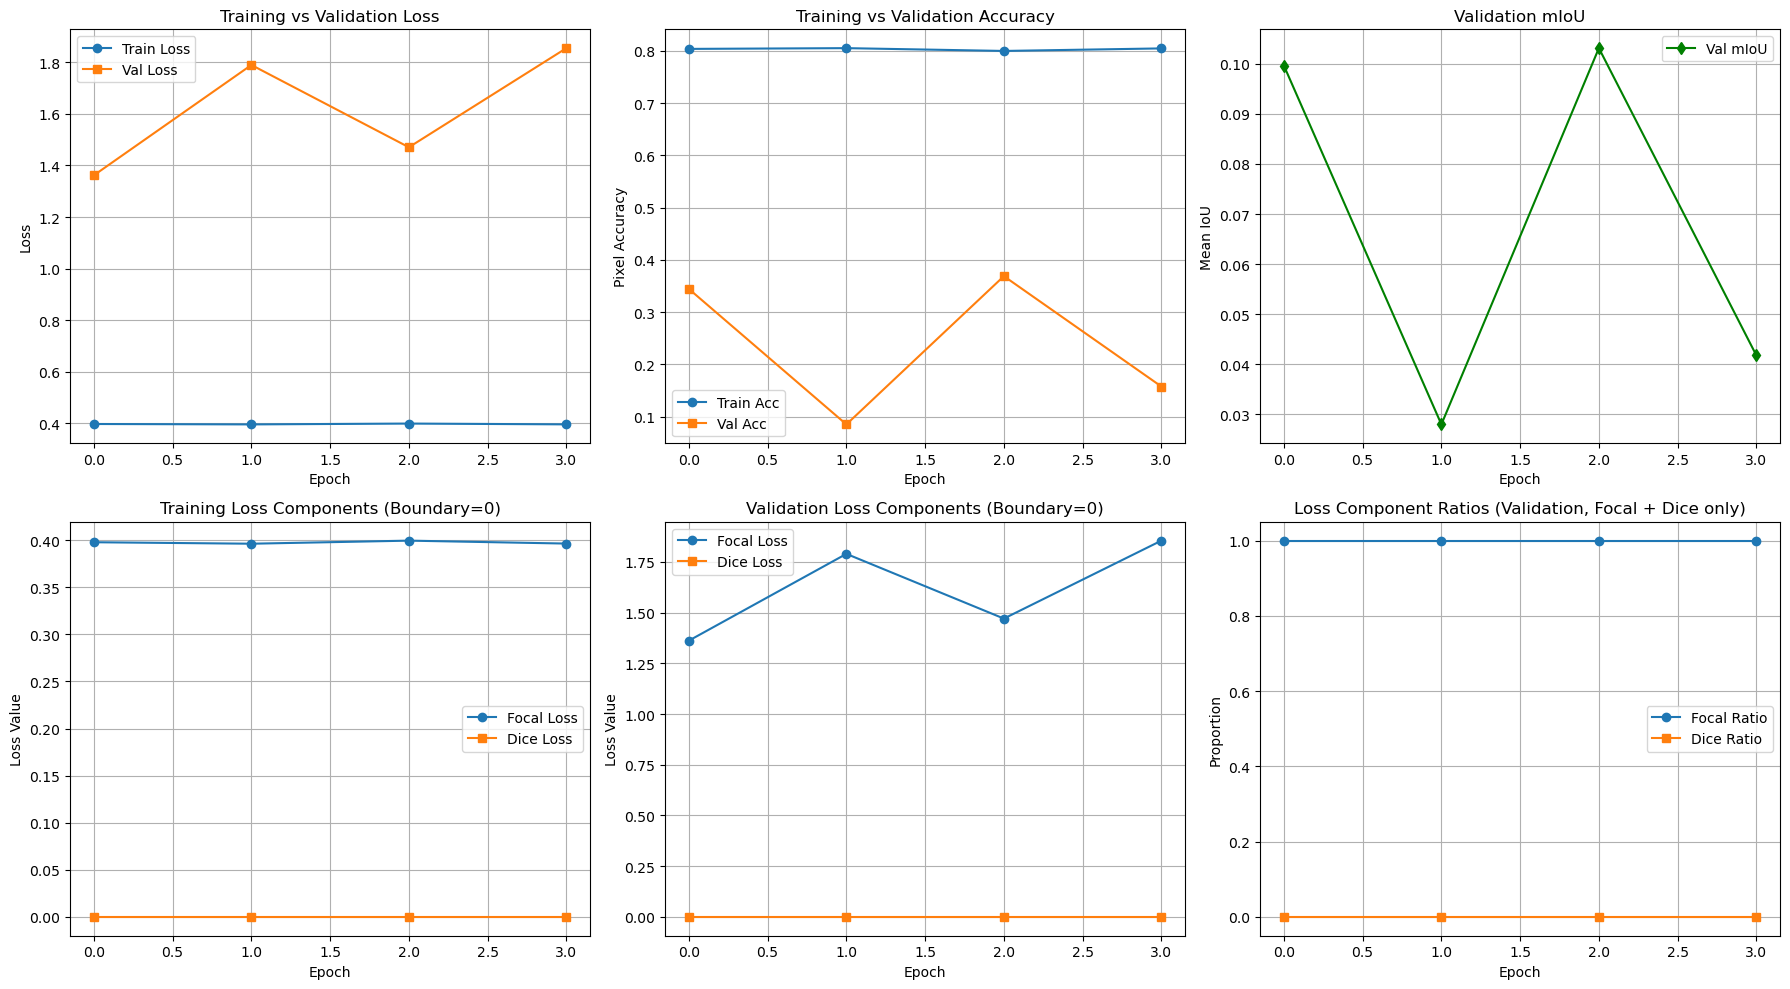

In [14]:
# ===========================================
# Cell 11. Plot Training History (Enhanced)
# ===========================================

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Loss
axes[0, 0].plot(history["train_loss"], label="Train Loss", marker='o')
axes[0, 0].plot(history["val_loss"], label="Val Loss", marker='s')
axes[0, 0].set_xlabel("Epoch")
axes[0, 0].set_ylabel("Loss")
axes[0, 0].set_title("Training vs Validation Loss")
axes[0, 0].legend()
axes[0, 0].grid(True)

# Accuracy
axes[0, 1].plot(history["train_acc"], label="Train Acc", marker='o')
axes[0, 1].plot(history["val_acc"], label="Val Acc", marker='s')
axes[0, 1].set_xlabel("Epoch")
axes[0, 1].set_ylabel("Pixel Accuracy")
axes[0, 1].set_title("Training vs Validation Accuracy")
axes[0, 1].legend()
axes[0, 1].grid(True)

# mIoU
axes[0, 2].plot(history["val_miou"], label="Val mIoU", marker='d', color='green')
axes[0, 2].set_xlabel("Epoch")
axes[0, 2].set_ylabel("Mean IoU")
axes[0, 2].set_title("Validation mIoU")
axes[0, 2].legend()
axes[0, 2].grid(True)

# Loss Components - Training
axes[1, 0].plot(history["train_loss_focal"], label="Focal Loss", marker='o')
axes[1, 0].plot(history["train_loss_dice"], label="Dice Loss", marker='s')
# axes[1, 0].plot(history["train_loss_boundary"], label="Boundary Loss", marker='^')
axes[1, 0].set_xlabel("Epoch")
axes[1, 0].set_ylabel("Loss Value")
axes[1, 0].set_title("Training Loss Components (Boundary=0)")
axes[1, 0].legend()
axes[1, 0].grid(True)

# Loss Components - Validation
axes[1, 1].plot(history["val_loss_focal"], label="Focal Loss", marker='o')
axes[1, 1].plot(history["val_loss_dice"], label="Dice Loss", marker='s')
# axes[1, 1].plot(history["val_loss_boundary"], label="Boundary Loss", marker='^')
axes[1, 1].set_xlabel("Epoch")
axes[1, 1].set_ylabel("Loss Value")
axes[1, 1].set_title("Validation Loss Components (Boundary=0)")
axes[1, 1].legend()
axes[1, 1].grid(True)

# Loss ratio analysis
if len(history["val_loss_focal"]) > 0:
    total = np.array(history["val_loss_focal"]) + np.array(history["val_loss_dice"]) # + np.array(history["val_loss_boundary"])
    focal_ratio = np.array(history["val_loss_focal"]) / (total + 1e-9)
    dice_ratio = np.array(history["val_loss_dice"]) / (total + 1e-9)
    # bnd_ratio = np.array(history["val_loss_boundary"]) / (total + 1e-9)
    
    axes[1, 2].plot(focal_ratio, label="Focal Ratio", marker='o')
    axes[1, 2].plot(dice_ratio, label="Dice Ratio", marker='s')
    # axes[1, 2].plot(bnd_ratio, label="Boundary Ratio", marker='^')
    axes[1, 2].set_xlabel("Epoch")
    axes[1, 2].set_ylabel("Proportion")
    axes[1, 2].set_title("Loss Component Ratios (Validation, Focal + Dice only)")
    axes[1, 2].legend()
    axes[1, 2].grid(True)

plt.tight_layout()
plt.savefig(f"training_history_ver6_{ablation}_enhanced.png", dpi=150)
plt.show()

In [15]:
# ===========================================
# Cell 12. Spectral Attention Visualization
# ===========================================

def visualize_spectral_attention(model, loader, num_samples=3):
    """Visualize learned spectral attention weights"""

    # Jika model adalah baseline, yang mana tidak menggunakan SA, maka skip cell ini
    if not model.use_attention:
        print("\n" + "="*60)
        print("SPECTRAL ATTENTION VISUALIZATION")
        print("="*60)
        print("[INFO] Attention is DISABLED (baseline model)")
        print("       Skipping visualization")
        return
    
    model.eval()
    
    attention_weights_list = []
    sample_images = []
    
    with torch.no_grad():
        for i, (xb, yb) in enumerate(loader):
            if i >= num_samples:
                break
            
            xb = xb.to(device)
            _ = model(xb)  # Forward pass
            
            # Get attention weights
            attn_weights = model.get_attention_weights()
            if attn_weights is not None:
                attention_weights_list.append(attn_weights[0].cpu().numpy())
                sample_images.append(xb[0])
    
    if not attention_weights_list:
        print("No attention weights captured!")
        return
    
    # Plot attention weights
    fig, axes = plt.subplots(num_samples, 2, figsize=(14, 4*num_samples))
    
    for i in range(num_samples):
        # Attention weights
        attn = attention_weights_list[i]
        axes[i, 0].bar(range(len(attn)), attn, color='steelblue', alpha=0.7)
        axes[i, 0].set_xlabel("Spectral Channel (after 3D CNN)")
        axes[i, 0].set_ylabel("Attention Weight")
        axes[i, 0].set_title(f"Sample {i+1}: Learned Spectral Attention")
        axes[i, 0].grid(True, alpha=0.3)
        
        # Top-k important channels
        top_k = 10
        top_indices = np.argsort(attn)[-top_k:]
        axes[i, 0].bar(top_indices, attn[top_indices], color='red', alpha=0.7, 
                       label=f'Top-{top_k} channels')
        axes[i, 0].legend()
        
        # Original hyperspectral signature (averaged)
        img = sample_images[i].cpu().numpy()  # [Bands, H, W]
        mean_spectrum = img.mean(axis=(1, 2))
        
        axes[i, 1].plot(mean_spectrum, color='darkgreen', linewidth=1.5)
        axes[i, 1].set_xlabel("Original Spectral Band")
        axes[i, 1].set_ylabel("Mean Reflectance")
        axes[i, 1].set_title(f"Sample {i+1}: Mean Spectral Signature")
        axes[i, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"spectral_attention_weights_ver6_{ablation}.png", dpi=150)
    plt.show()
    
    # Print statistics
    print("\n" + "="*60)
    print("SPECTRAL ATTENTION ANALYSIS")
    print("="*60)
    for i, attn in enumerate(attention_weights_list):
        top_5_idx = np.argsort(attn)[-5:]
        print(f"\nSample {i+1}:")
        print(f"  Mean attention: {attn.mean():.4f}")
        print(f"  Std attention: {attn.std():.4f}")
        print(f"  Max attention: {attn.max():.4f}")
        print(f"  Top-5 channels: {top_5_idx} with weights {attn[top_5_idx]}")

# Visualize attention on validation set
print("\nVisualizing spectral attention weights...")
visualize_spectral_attention(model, val_loader, num_samples=3)


Visualizing spectral attention weights...

SPECTRAL ATTENTION VISUALIZATION
[INFO] Attention is DISABLED (baseline model)
       Skipping visualization


C:\Users\admin\AppData\Local\Temp\ipykernel_15584\4152879093.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_checkpoint = torch.load(best_model_path, map_location=d

Loaded best model from epoch 27



TEST RESULTS
Test Loss     : 1.6256
  ├─ Focal Loss  : 1.6256
  ├─ Dice Loss: 0.0000
  └─ Bnd Loss : 0.0000
Test Accuracy : 0.5668
Test mIoU     : 0.1184
IoU per class : [0.         0.         0.040382   0.         0.0019237  0.66796386]

GENERATING SEGMENTATION MAPS
Sample 1: Input shape torch.Size([1, 300, 96, 96]), Output shape torch.Size([1, 96, 96])
Sample 2: Input shape torch.Size([1, 300, 96, 96]), Output shape torch.Size([1, 96, 96])
Sample 3: Input shape torch.Size([1, 300, 96, 96]), Output shape torch.Size([1, 96, 96])
Sample 4: Input shape torch.Size([1, 300, 96, 96]), Output shape torch.Size([1, 96, 96])
Sample 5: Input shape torch.Size([1, 300, 96, 96]), Output shape torch.Size([1, 96, 96])

Generating visualizations...
Visualizing sample 1/5


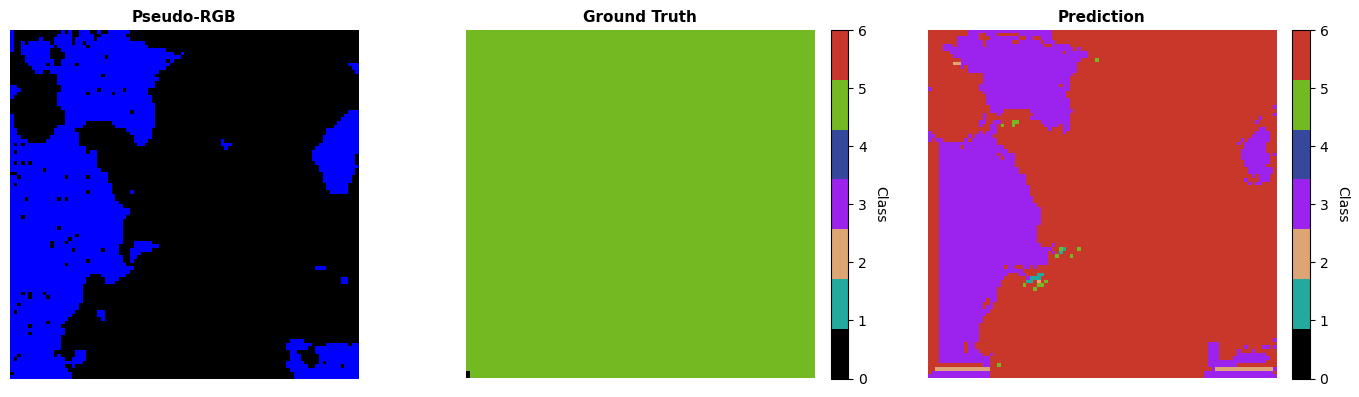

Visualizing sample 2/5


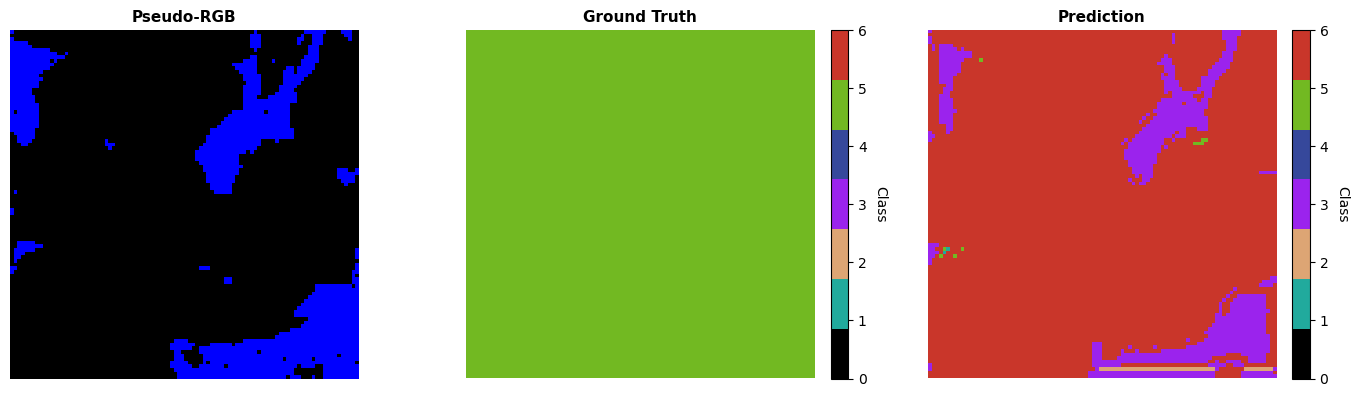

Visualizing sample 3/5


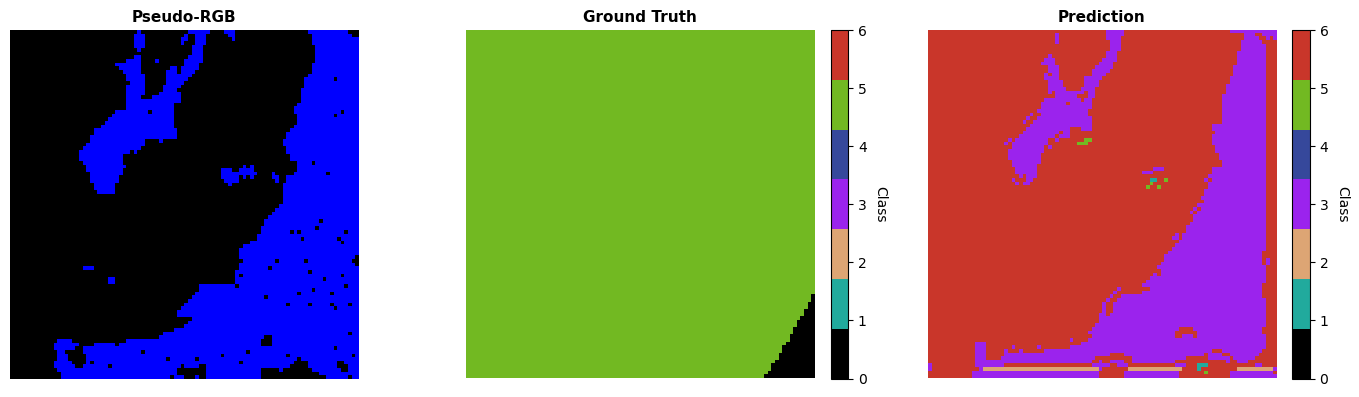

Visualizing sample 4/5


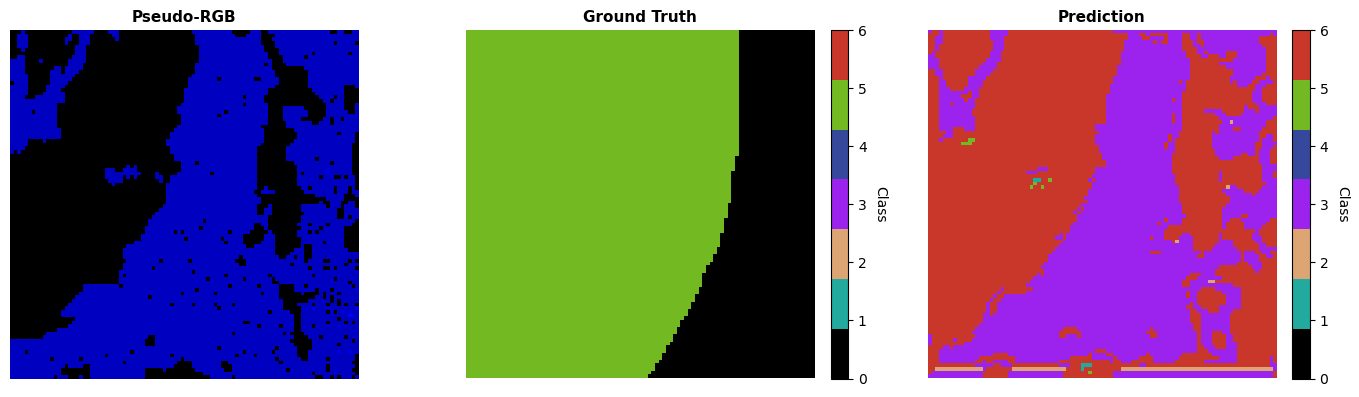

Visualizing sample 5/5


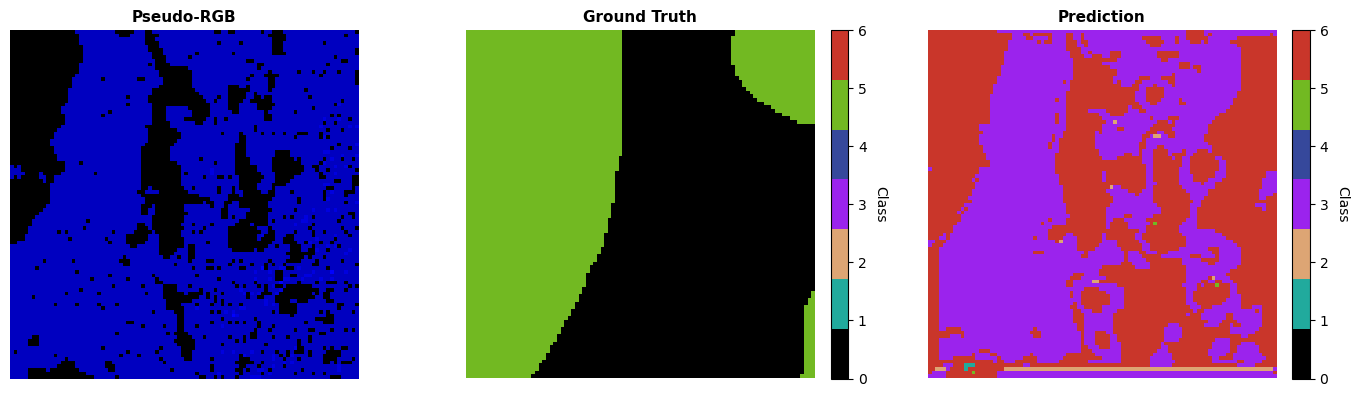


[OK] Output: SEGMENTATION MAPS
  Format: [H, W] dengan setiap pixel berisi class label (0-6)
  Visualisasi: Setiap warna merepresentasikan habitat class berbeda


In [16]:
# ===========================================
# Cell 13. Testing dan Visualisasi Output Segmentation
# ===========================================

# Load best model
best_checkpoint = torch.load(best_model_path, map_location=device)
model.load_state_dict(best_checkpoint["model_state"])
print(f"Loaded best model from epoch {best_checkpoint['epoch']}")

# Test evaluation
test_metrics = SegmentationMetrics(num_classes_actual, ignore_index=0)
test_loss, test_acc, test_miou, test_iou_per_class, test_focal, test_dice, test_bnd = validate(
    model, test_loader, criterion, test_metrics, device
)

print("\n" + "="*60)
print("TEST RESULTS")
print("="*60)
print(f"Test Loss     : {test_loss:.4f}")
print(f"  ├─ Focal Loss  : {test_focal:.4f}") # rename ce menjadi focal 
print(f"  ├─ Dice Loss: {test_dice:.4f}")
print(f"  └─ Bnd Loss : {test_bnd:.4f}")
print(f"Test Accuracy : {test_acc:.4f}")
print(f"Test mIoU     : {test_miou:.4f}")
print(f"IoU per class : {test_iou_per_class[1:]}")

# Visualisasi beberapa prediksi SEGMENTATION MAP
model.eval()
num_vis = 5
vis_samples = []

print("\n" + "="*60)
print("GENERATING SEGMENTATION MAPS")
print("="*60)

with torch.no_grad():
    for i, (xb, yb) in enumerate(test_loader):
        if i >= num_vis:
            break
        xb = xb.to(device)
        logits = model(xb)
        preds = logits.argmax(dim=1)  # [B, H, W] - SEGMENTATION MAP
        
        vis_samples.append((xb[0], yb[0], preds[0]))
        print(f"Sample {i+1}: Input shape {xb.shape}, Output shape {preds.shape}")

# Plot visualisasi segmentation maps
print("\nGenerating visualizations...")
for i, (x, y_true, y_pred) in enumerate(vis_samples):
    print(f"Visualizing sample {i+1}/{num_vis}")
    visualize_tile(x, y_true.cpu().numpy(), y_pred.cpu().numpy(), 
                   cmap=global_cmap, idx=i)

print("\n[OK] Output: SEGMENTATION MAPS")
print("  Format: [H, W] dengan setiap pixel berisi class label (0-6)")
print("  Visualisasi: Setiap warna merepresentasikan habitat class berbeda")

Computing CM: 100%|████████████████████████████████████████████████████████████████| 2338/2338 [01:52<00:00, 20.70it/s]


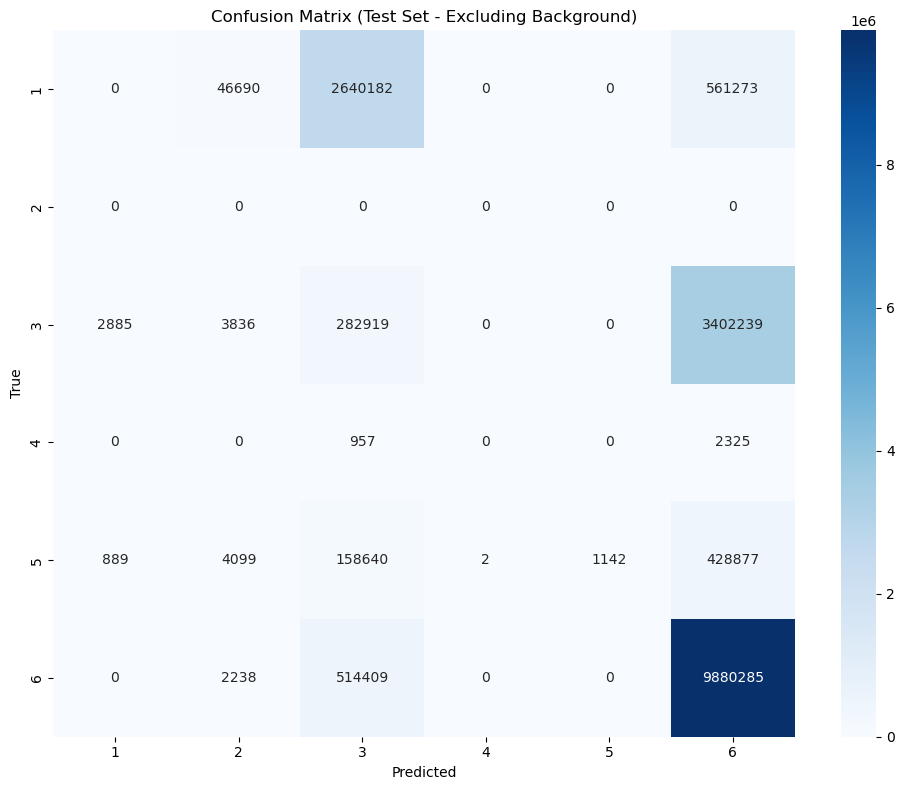


CONFUSION PATTERN ANALYSIS

Top 10 Misclassifications:
True   → Pred   Count        % of True Class
--------------------------------------------------
3      → 6        3,402,239     92.2%
1      → 3        2,640,182     81.3%
1      → 6        561,273       17.3%
6      → 3        514,409        4.9%
5      → 6        428,877       72.2%
5      → 3        158,640       26.7%
1      → 2        46,690         1.4%
5      → 2        4,099          0.7%
3      → 2        3,836          0.1%
3      → 1        2,885          0.1%

⚠️ PROBLEMATIC CLASS PAIRS (>30% confusion):
  Class 3 → Class 6: 92.2% misclassified
  Class 1 → Class 3: 81.3% misclassified
  Class 5 → Class 6: 72.2% misclassified
  Class 4 → Class 6: 70.8% misclassified
Confusion matrix saved!


In [17]:
# ===========================================
# Cell 14. Confusion Matrix
# ===========================================

from sklearn.metrics import confusion_matrix
import seaborn as sns

def analyze_confusion_patterns(cm):
    """
    Analyze which classes are commonly confused
    """
    print("\n" + "="*60)
    print("CONFUSION PATTERN ANALYSIS")
    print("="*60)
    
    # Normalize confusion matrix (row-wise)
    cm_norm = cm.astype('float') / (cm.sum(axis=1, keepdims=True) + 1e-9)
    
    # Find top confusions
    confusions = []
    for i in range(len(cm)):
        for j in range(len(cm)):
            if i != j and cm[i, j] > 0:
                # (true_class, pred_class, count, percentage)
                confusions.append((i+1, j+1, cm[i, j], cm_norm[i, j]))
    
    # Sort by count
    confusions.sort(key=lambda x: x[2], reverse=True)
    
    print("\nTop 10 Misclassifications:")
    print(f"{'True':<6} {'→ Pred':<8} {'Count':<12} {'% of True Class'}")
    print("-" * 50)
    
    for true_cls, pred_cls, count, pct in confusions[:10]:
        print(f"{true_cls:<6} → {pred_cls:<8} {count:<12,} {pct*100:>5.1f}%")
    
    # Identify problematic pairs
    print("\n⚠️ PROBLEMATIC CLASS PAIRS (>30% confusion):")
    for true_cls, pred_cls, count, pct in confusions:
        if pct > 0.3:
            print(f"  Class {true_cls} → Class {pred_cls}: {pct*100:.1f}% misclassified")

# Collect predictions untuk confusion matrix
all_preds = []
all_targets = []

model.eval()
with torch.no_grad():
    for xb, yb in tqdm(test_loader, desc="Computing CM"):
        xb = xb.to(device)
        logits = model(xb)
        preds = logits.argmax(dim=1)
        
        # Flatten dan filter valid pixels
        preds_flat = preds.cpu().numpy().flatten()
        targets_flat = yb.numpy().flatten()
        
        valid = targets_flat != 0  # Exclude background
        all_preds.extend(preds_flat[valid])
        all_targets.extend(targets_flat[valid])

# Compute confusion matrix
cm = confusion_matrix(all_targets, all_preds, labels=list(range(1, num_classes_actual)))

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(1, num_classes_actual),
            yticklabels=range(1, num_classes_actual))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test Set - Excluding Background)')
plt.tight_layout()
plt.savefig(f'confusion_matrix_ver6_{ablation}.png', dpi=150)
plt.show()

analyze_confusion_patterns(cm)

print("Confusion matrix saved!")


FULL IMAGE SEGMENTATION (MEMORY EFFICIENT)
Selected image: massimal_smola_maholmen_202306211129-2_hsi_003_test_x.npy
Available GPU memory: 17.06 GB
Auto batch size: 16
[INFO] Loading full image: massimal_smola_maholmen_202306211129-2_hsi_003_test_x.npy
[INFO] Image shape: (580, 900, 300)
[INFO] Memory usage: ~0.63 GB if fully loaded
[INFO] Processing 187 tiles in batches of 2
[INFO] Expected memory: ~0.02 GB per batch
  Processed 100/187 tiles (53.5%)
  Processed 187/187 tiles (100.0%)
[INFO] Computing final prediction...
[INFO] Applying smoothing (median filter)...
[INFO] Segmentation complete!
[INFO] Unique classes predicted: [0 1 2 3 5 6]
[INFO] Ground truth loaded. Unique classes: [ 0 13 14 18]

[METRICS] Full Image:
  Pixel Accuracy: 0.0334
  Mean IoU: 0.0265
  IoU per class: [np.float64(0.0), np.float64(0.0), np.float64(0.0520780388630405), np.float64(0.0), np.float64(0.000866604766326204), np.float64(0.0)]


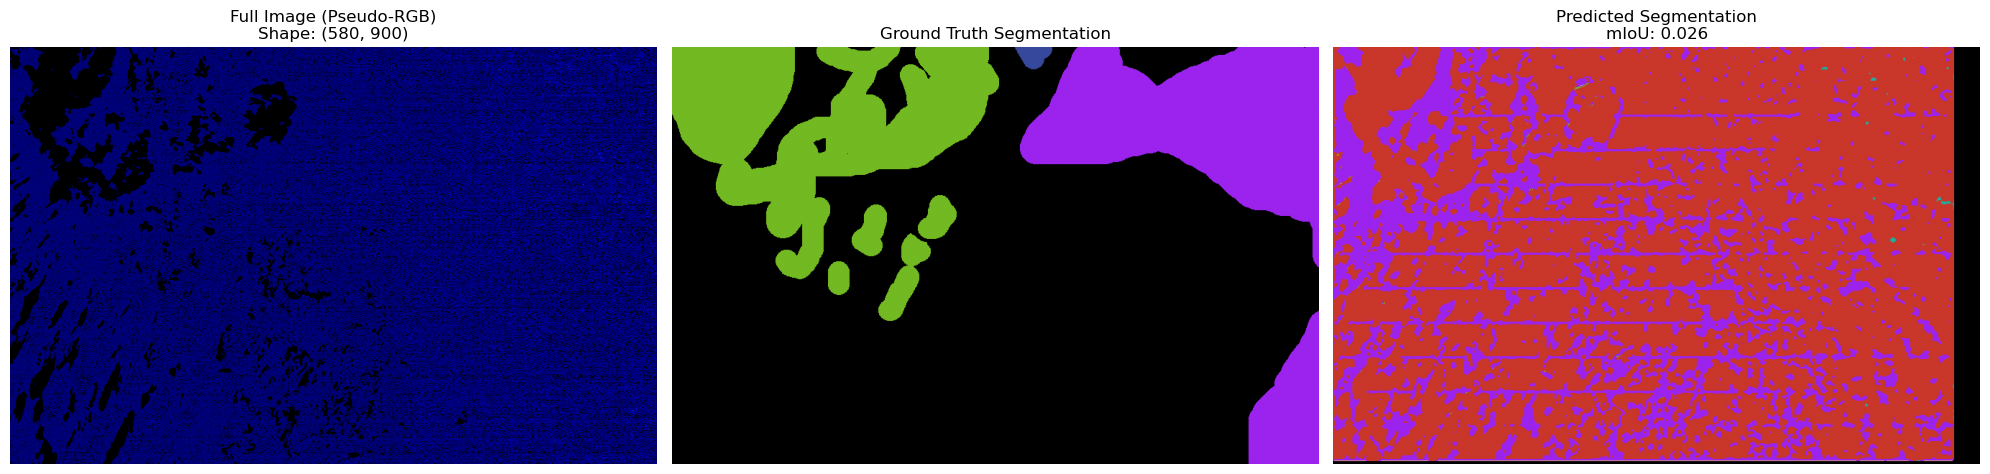


[OK] Saved: full_image_segmentation_fixed.png


In [18]:
# ===========================================
# Cell 15NEW. FIXED Full Image Segmentation (Memory Efficient)
# ===========================================
from scipy.ndimage import distance_transform_edt, median_filter
def smooth_prediction_map(pred_map, kernel_size=5):
    """
    Smooth prediction to reduce grid artifacts
    Uses median filter to preserve boundaries
    """
    return median_filter(pred_map, size=kernel_size)

def segment_full_image_memory_efficient(model, image_path, mask_path=None, 
                                        tile_size=96, stride=32, device='cuda',
                                        batch_size=16):
    """
    FIXED: Memory-efficient full image segmentation
    
    Changes from original:
    1. Process in batches to avoid OOM
    2. Use float16 for accumulator (half memory)
    3. Clear cache periodically
    4. Use mmap for input (no full load)
    5. stride: tile_size/2 → tile_size/3 (67% overlap, was 50%)
    6. Add smoothing at the end
    """
    model.eval()
    
    print(f"[INFO] Loading full image: {os.path.basename(image_path)}")
    
    # Load with mmap (don't load entire file)
    x_full = np.load(image_path, mmap_mode='r')  # [H, W, Bands]
    H, W, B = x_full.shape
    print(f"[INFO] Image shape: {x_full.shape}")
    print(f"[INFO] Memory usage: ~{H*W*B*4/1e9:.2f} GB if fully loaded")
    
    # Prepare output with FLOAT16 (half memory!)
    prediction_accumulator = np.zeros((num_classes_actual, H, W), dtype=np.float16)
    count_map = np.zeros((H, W), dtype=np.float16)
    
    # Calculate number of tiles
    n_tiles_h = (H - tile_size) // stride + 1
    n_tiles_w = (W - tile_size) // stride + 1
    total_tiles = n_tiles_h * n_tiles_w
    
    print(f"[INFO] Processing {total_tiles} tiles in batches of {batch_size}")
    print(f"[INFO] Expected memory: ~{batch_size*tile_size*tile_size*B*4/1e9:.2f} GB per batch")
    
    # Collect tile positions
    tile_positions = []
    for i in range(0, H - tile_size + 1, stride):
        for j in range(0, W - tile_size + 1, stride):
            tile_positions.append((i, j))
    
    # Process in batches
    with torch.no_grad():
        for batch_start in range(0, len(tile_positions), batch_size):
            batch_end = min(batch_start + batch_size, len(tile_positions))
            batch_tiles = []
            batch_positions = []
            
            # Load batch of tiles
            for idx in range(batch_start, batch_end):
                i, j = tile_positions[idx]
                
                # Load tile from mmap (efficient!)
                tile = x_full[i:i+tile_size, j:j+tile_size, :].copy()
                
                # Normalize
                tile = normalize_reflectance(tile)
                
                # To tensor
                tile_tensor = torch.from_numpy(tile.transpose(2, 0, 1)).float()
                batch_tiles.append(tile_tensor)
                batch_positions.append((i, j))
            
            # Stack batch
            batch_tensor = torch.stack(batch_tiles).to(device)
            
            # Predict
            logits = model(batch_tensor)  # [B, C, H, W]
            probs = F.softmax(logits, dim=1).cpu().numpy().astype(np.float16)  # FLOAT16!
            
            # Accumulate
            for k, (i, j) in enumerate(batch_positions):
                prediction_accumulator[:, i:i+tile_size, j:j+tile_size] += probs[k]
                count_map[i:i+tile_size, j:j+tile_size] += 1
            
            # Progress
            processed = batch_end
            if processed % 100 == 0 or processed == len(tile_positions):
                print(f"  Processed {processed}/{len(tile_positions)} tiles ({processed/len(tile_positions)*100:.1f}%)")
            
            # Clear GPU cache every 10 batches
            if (batch_start // batch_size) % 10 == 0:
                torch.cuda.empty_cache()
    
    # Average and get final prediction
    print(f"[INFO] Computing final prediction...")
    prediction_accumulator = prediction_accumulator.astype(np.float32)  # Convert back for division
    count_map = count_map.astype(np.float32)
    prediction_accumulator /= (count_map[np.newaxis, :, :] + 1e-9)
    
    final_pred = prediction_accumulator.argmax(axis=0).astype(np.int32)
    
    # ADD SMOOTHING
    print(f"[INFO] Applying smoothing (median filter)...")
    final_pred = smooth_prediction_map(final_pred, kernel_size=5)
    
    print(f"[INFO] Segmentation complete!")
    print(f"[INFO] Unique classes predicted: {np.unique(final_pred)}")
    
    # Load ground truth if provided
    ground_truth = None
    if mask_path and os.path.exists(mask_path):
        ground_truth = np.load(mask_path, mmap_mode='r').copy()
        print(f"[INFO] Ground truth loaded. Unique classes: {np.unique(ground_truth)}")
        
        # Remap ground truth
        if label_remap is not None:
            gt_remap = np.zeros_like(ground_truth, dtype=np.int32)
            for orig_label, new_idx in label_remap.items():
                gt_remap[ground_truth == orig_label] = new_idx
            ground_truth = gt_remap
    
    return final_pred, x_full, ground_truth

# ===========================================
# USAGE: Full Image Segmentation (Memory Safe)
# ===========================================

print("\n" + "="*60)
print("FULL IMAGE SEGMENTATION (MEMORY EFFICIENT)")
print("="*60)

# Select a test image
test_file_idx = 0
test_file_x = test_pairs[test_file_idx][0]
test_file_y = test_pairs[test_file_idx][1]

print(f"Selected image: {os.path.basename(test_file_x)}")

# Check available GPU memory
if torch.cuda.is_available():
    free_mem = torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_allocated()
    print(f"Available GPU memory: {free_mem/1e9:.2f} GB")
    
    # Adjust batch size based on available memory
    if free_mem < 2e9:  # Less than 2GB
        batch_size_auto = 4
    elif free_mem < 4e9:  # Less than 4GB
        batch_size_auto = 8
    else:
        batch_size_auto = 16
    
    print(f"Auto batch size: {batch_size_auto}")
else:
    batch_size_auto = 4


# Perform segmentation
try:
    full_pred, full_img, full_gt = segment_full_image_memory_efficient(
        model, 
        test_file_x, 
        test_file_y,
        tile_size=TILE_SIZE, 
        stride=TILE_SIZE // 2,  # 50% overlap
        device=device,
        # batch_size=batch_size_auto
        batch_size=2
    )
    
    # Calculate metrics
    if full_gt is not None:
        valid_mask = (full_gt != 0)
        if valid_mask.sum() > 0:
            valid_pred = full_pred[valid_mask]
            valid_gt = full_gt[valid_mask]
            
            full_acc = (valid_pred == valid_gt).sum() / len(valid_pred)
            
            # Calculate IoU per class
            full_iou_per_class = []
            for cls in range(1, num_classes_actual):
                pred_i = (valid_pred == cls)
                gt_i = (valid_gt == cls)
                intersection = (pred_i & gt_i).sum()
                union = (pred_i | gt_i).sum()
                iou = intersection / (union + 1e-9) if union > 0 else 0.0
                full_iou_per_class.append(iou)
            
            full_miou = np.mean([iou for iou in full_iou_per_class if iou > 0])
            
            print(f"\n[METRICS] Full Image:")
            print(f"  Pixel Accuracy: {full_acc:.4f}")
            print(f"  Mean IoU: {full_miou:.4f}")
            print(f"  IoU per class: {full_iou_per_class}")
    
    # Visualize (downsample for display)
    scale = min(1.0, 1000 / max(full_pred.shape))
    if scale < 1.0:
        from scipy.ndimage import zoom
        display_pred = zoom(full_pred, scale, order=0)
        if full_gt is not None:
            display_gt = zoom(full_gt, scale, order=0)
        
        # RGB
        rgb_idx = [int(full_img.shape[2]*0.05), int(full_img.shape[2]*0.5), int(full_img.shape[2]*0.9)]
        rgb_small = full_img[::int(1/scale), ::int(1/scale), rgb_idx]
    else:
        display_pred = full_pred
        display_gt = full_gt
        rgb_idx = [int(full_img.shape[2]*0.05), int(full_img.shape[2]*0.5), int(full_img.shape[2]*0.9)]
        rgb_small = full_img[:, :, rgb_idx]
    
    rgb_norm = (rgb_small - rgb_small.min()) / (rgb_small.max() - rgb_small.min() + 1e-9)
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    axes[0].imshow(rgb_norm)
    axes[0].set_title(f"Full Image (Pseudo-RGB)\nShape: {full_img.shape[:2]}", fontsize=12)
    axes[0].axis('off')
    
    if full_gt is not None:
        axes[1].imshow(display_gt, cmap=global_cmap, vmin=0, vmax=num_classes_actual-1)
        axes[1].set_title("Ground Truth Segmentation", fontsize=12)
        axes[1].axis('off')
    
    axes[2].imshow(display_pred, cmap=global_cmap, vmin=0, vmax=num_classes_actual-1)
    axes[2].set_title(f"Predicted Segmentation\nmIoU: {full_miou:.3f}" if full_gt is not None else "Predicted Segmentation", fontsize=12)
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.savefig('full_image_segmentation_fixed.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\n[OK] Saved: full_image_segmentation_fixed.png")
    
except RuntimeError as e:
    if "out of memory" in str(e):
        print(f"\n❌ STILL OUT OF MEMORY!")
        print(f"   Try reducing batch_size further:")
        print(f"   batch_size=4 → batch_size=2 or batch_size=1")
        torch.cuda.empty_cache()
    else:
        raise e
except Exception as e:
    print(f"\n❌ ERROR: {e}")
    import traceback
    traceback.print_exc()



In [ ]:
# ===========================================
# Cell 15b. Dataset Distribution Analysis (untuk solusi test set issue)
# ===========================================

print("\n" + "="*60)
print("DATASET CLASS DISTRIBUTION ANALYSIS")
print("="*60)

def analyze_file_distribution(pairs, split_name):
    """Analisis distribusi kelas per file"""
    print(f"\n{split_name} Split Analysis:")
    print(f"{'='*50}")
    
    file_class_info = []
    
    for idx, (fx, fy) in enumerate(pairs):
        y = np.load(fy, mmap_mode='r')
        unique, counts = np.unique(y, return_counts=True)
        
        # Convert to dict
        class_dist = dict(zip(unique.tolist(), counts.tolist()))
        
        # Get remapped classes
        remapped_dist = {}
        for orig, cnt in class_dist.items():
            if orig in label_remap:
                new_idx = label_remap[orig]
                remapped_dist[new_idx] = cnt
        
        file_class_info.append({
            'file': os.path.basename(fx),
            'distribution': remapped_dist,
            'classes_present': sorted(remapped_dist.keys())
        })
        
        print(f"\nFile {idx+1}: {os.path.basename(fx)}")
        print(f"  Classes present: {sorted(remapped_dist.keys())}")
        print(f"  Pixel counts: {remapped_dist}")
    
    # Summary
    all_classes = set()
    for info in file_class_info:
        all_classes.update(info['classes_present'])
    
    print(f"\n{split_name} Summary:")
    print(f"  Total files: {len(pairs)}")
    print(f"  Classes covered: {sorted(all_classes)}")
    print(f"  Missing classes: {set(range(num_classes_actual)) - all_classes}")
    
    return file_class_info

# Analyze all splits
train_analysis = analyze_file_distribution(train_pairs, "TRAIN")
val_analysis = analyze_file_distribution(val_pairs, "VALIDATION")
test_analysis = analyze_file_distribution(test_pairs, "TEST")

# Check coverage
print("\n" + "="*60)
print("OVERALL COVERAGE CHECK")
print("="*60)

all_train_classes = set()
all_val_classes = set()
all_test_classes = set()

for info in train_analysis:
    all_train_classes.update(info['classes_present'])
for info in val_analysis:
    all_val_classes.update(info['classes_present'])
for info in test_analysis:
    all_test_classes.update(info['classes_present'])

print(f"\nClasses in Train: {sorted(all_train_classes)}")
print(f"Classes in Val:   {sorted(all_val_classes)}")
print(f"Classes in Test:  {sorted(all_test_classes)}")

missing_in_test = all_train_classes - all_test_classes
if missing_in_test:
    print(f"\n [WARNING]: Classes {sorted(missing_in_test)} are in TRAIN but NOT in TEST!")
    print(f"   This means we cannot evaluate model performance on these classes.")
    
    # Suggest rebalancing
    print(f"\n💡 RECOMMENDATION:")
    print(f"   Option 1: Move files from train/val to test that contain classes {sorted(missing_in_test)}")
    
    # Find files in train that have missing classes
    candidate_files = []
    for info in train_analysis:
        if missing_in_test & set(info['classes_present']):
            candidate_files.append((info['file'], info['classes_present']))
    
    if candidate_files:
        print(f"\n   Candidate files to move to test set:")
        for fname, classes in candidate_files[:3]:  # Show top 3
            print(f"     - {fname}: has classes {sorted(classes)}")
else:
    print(f"\n✓ All classes are represented in test set!")

In [ ]:
# ===========================================
# Cell 17. Save Results Summary
# ===========================================

results_summary = {
    "model": "SpectralAttentionHybridSN",
    "version": "v4_improved",
    "novelties": ["Spectral Self-Attention", "Multi-Objective Loss (Focal+Dice+Boundary)"],
    "improvements": [
        "Learning rate: 5e-6 → 1e-4",
        "Tile size: 32 → 64",
        "Boundary loss weight: 0.5 → 0.1",
        "Data augmentation: flip + rotation",
        "Focal loss replacing CE",
        "Early stopping patience: 10 → 15"
    ],
    "hyperparameters": {
        "learning_rate": LR,
        "batch_size": BATCH_SIZE,
        "accumulation_steps": ACCUMULATION_STEPS,
        "tile_size": TILE_SIZE,
        "num_epochs": NUM_EPOCHS,
        "attention_reduction": 16,
        "loss_weights": {"focal": 1.0, "dice": 1.0, "boundary": 0.1},
        "focal_gamma": 2.0,
        "early_stopping_patience": 15
    },
    "test_results": {
        "pixel_accuracy": float(test_acc),
        "mean_iou": float(test_miou),
        "loss_total": float(test_loss),
        "loss_focal": float(test_focal),
        "loss_dice": float(test_dice),
        "loss_boundary": float(test_bnd),
        "iou_per_class": test_iou_per_class.tolist()
    },
    "training_history": history
}

# Save to JSON
with open(f"results_ver6_{ablation}_summary.json", "w") as f:
    json.dump(results_summary, f, indent=2)

print("\n" + "="*60)
print("EXPERIMENT SUMMARY")
print("="*60)
print(json.dumps(results_summary["test_results"], indent=2))
print(f"\nResults saved to: results_ver6_{ablation}_summary.json")
print("\n[OK]Training complete!")